### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
model_name = 'model-08-keras-search-long'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2
debugging = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 5709.20035 'divorce_rate' 3.333296666667593]
 [1 5709.200316666666 'I_250' 3.333263333333889]
 [2 5708.200346666667 'XI_100' 2.33329333333495]
 [3 5707.867050000001 'VI_index_500' 1.9999966666682667]
 [4 5707.86704 'IX_index_50' 1.9999866666676098]
 [5 5707.866983333333 'VI_500' 1.9999300000008589]
 [6 5707.533710000001 'XIV_10' 1.666656666668132]
 [7 5707.200386666666 'XI_index_500' 1.3333333333339397]
 [8 5707.200383333334 'VI_index_1000' 1.3333300000012969]
 [9 5707.200373333333 'V_100' 1.33332000000064]
 [10 5707.200363333334 'VII_10' 1.333310000001802]
 [11 5707.200336666666 'X_100' 1.3332833333333838]
 [12 5706.867056666667 'XII_index_50' 1.0000033333344618]
 [15 5706.867050000001 'X_index_500' 0.9999966666682667]
 [14 5706.867050000001 'X_10' 0.9999966666682667]
 [13 5706.867050000001 'II_10' 0.9999966666682667]
 [16 5706.867046666666 'II_index_500' 0.9999933333338049]
 [17 5706.867046666666 'V_index_1000' 0.9999933333338049]
 [18 5706.867043333335 'XIII_10' 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
display(train.head(5))
display(test.head(5))

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv('dataset/id_cv'+str(i)+'.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.4622312795739
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.81980868401074
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.8005430183116
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906168328487
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.21309507601745


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: 146

Target mean encoded columns: 0

Right skew columns: 57


### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df, df_test):
        df = df.copy()   
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

#### Debug

In [13]:
# for debug only
feat_eng_t = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
dfp2 = feat_eng_t.fit_transform(train, test)
df_test_2 = feat_eng_t.transform(test)

In [14]:
for c in cols_cat:
    print(c, dfp2[c].min(), df_test_2[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 0 0
village 0 0
encoded_latlon 1 1


In [15]:
train.info()
dfp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 253 entries, building_id to land_per_building_area
dtypes: float32(145), int32(8), int64(10), object(90)
memory usage: 80.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 254 entries, building_id to log_per_area_total_price_scaled
dtypes: float32(146), int16(2), int64(10), int8(6), object(90)
memory usage: 79.8+ MB


In [16]:
dfp2['building_area_ori'].check()

0         3.418175
1         4.041309
2         5.584279
3        13.563030
4         4.688108
59995     6.754059
59996     5.356788
59997     8.223644
59998     8.728287
59999     5.356788
Name: building_area_ori, dtype: float32

shape = (60000,)


In [17]:
#dfp2.loc[:, cols_right_skew].check()

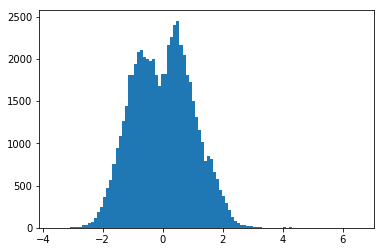

In [18]:
plt.hist(dfp2['log_per_area_total_price_scaled'], bins=100); plt.show()

In [19]:
if debugging:
    for c in cols_num:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('num: '+c); plt.show()
    for c in cols_bin:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('bin: '+c); plt.show()

In [20]:
if debugging:
    for c in cols_tar_encoded:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('tar: '+c); plt.show()

### Keras Model

In [21]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [22]:
from keras_get_best import GetBest
from keras_SGDRScheduler import SGDRScheduler

In [23]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Compute N parameters

In [24]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [25]:
print(best_n_neurons(ratios=(1,1,1,1), params=25159840, n_inputs=219))

(2859, 2859, 2859, 2859)


In [26]:
np.power(3, 1/3)

1.4422495703074083

In [27]:
25159840*1.5

37739760.0

In [28]:
print(best_n_neurons(ratios=(4,8,2,1), params=37739760, n_inputs=219))

(3440, 6880, 1720, 860)


In [29]:
1072*1.5

1608.0

### Params

In [30]:
params = {'epochs': 1608,
          'loss': 'mse',
          'batch_norm': True,
          'n_neurons': (3440, 6880, 1720, 860),
          'batch_size': 256,
          'embedding_ratio': 3,
         }

if debugging:  # debugging only
    print('Using debug parameters...')
    params = {'epochs': 20,
              'loss': 'mse',
              'batch_norm': True,
              'n_neurons': (10, 10, 10, 10),
              'batch_size': 128,
              'embedding_ratio': 3,
             }
print(params)

{'n_neurons': (3440, 6880, 1720, 860), 'batch_size': 256, 'embedding_ratio': 3, 'batch_norm': True, 'epochs': 1608, 'loss': 'mse'}


### kfold cross-predict

In [31]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    else:
        cat_n_classes = {}
    cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                              cat_n_classes[c]) for c in cat_n_classes}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
    print()

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

    # Train model
    hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')],
                     batch_size=params['batch_size'], epochs=params['epochs'])
    best_iterations.append(np.argmin(hist.history['val_loss'])+1)
    model.save_weights(model_name+'-weights-'+str(i)+'.h5')
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====


W0708 03:09:51.537368 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 03:09:51.580266 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 03:09:51.617516 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numerical input dims: 138
Embeding  input dims: {'parking_way': 4, 'city': 12, 'building_use': 11, 'building_type': 6, 'building_material': 10, 'town': 202, 'village': 2479, 'encoded_latlon': 7}
Embeding output dims: {'parking_way': 4, 'city': 8, 'building_use': 8, 'building_type': 6, 'building_material': 8, 'town': 16, 'village': 24, 'encoded_latlon': 7}
Total embedding output dims: 81



W0708 03:09:51.867553 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0708 03:09:52.365459 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0708 03:09:53.202368 140273177532160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 48000 samples, validate on 12000 samples
Epoch 1/1608
 - 18s - loss: 1.6795 - mean_absolute_error: 0.4555 - val_loss: 0.0980 - val_mean_absolute_error: 0.2356
Epoch 2/1608
 - 16s - loss: 0.0965 - mean_absolute_error: 0.2339 - val_loss: 0.1425 - val_mean_absolute_error: 0.2766
Epoch 3/1608
 - 16s - loss: 0.0812 - mean_absolute_error: 0.2146 - val_loss: 0.1066 - val_mean_absolute_error: 0.2435
Epoch 4/1608
 - 16s - loss: 0.0781 - mean_absolute_error: 0.2104 - val_loss: 0.0817 - val_mean_absolute_error: 0.2136
Epoch 5/1608
 - 16s - loss: 0.0703 - mean_absolute_error: 0.2006 - val_loss: 0.0753 - val_mean_absolute_error: 0.2029
Epoch 6/1608
 - 16s - loss: 0.0658 - mean_absolute_error: 0.1936 - val_loss: 0.0719 - val_mean_absolute_error: 0.1964
Epoch 7/1608
 - 16s - loss: 0.0630 - mean_absolute_error: 0.1897 - val_loss: 0.0724 - val_mean_absolute_error: 0.1978
Epoch 8/1608
 - 16s - loss: 0.0588 - mean_absolute_error: 0.1829 - val_loss: 0.0635 - val_mean_absolute_error: 0.1848
Epoch 

Epoch 70/1608
 - 16s - loss: 0.0179 - mean_absolute_error: 0.0983 - val_loss: 0.0613 - val_mean_absolute_error: 0.1724
Epoch 71/1608
 - 16s - loss: 0.0188 - mean_absolute_error: 0.1014 - val_loss: 0.0594 - val_mean_absolute_error: 0.1677
Epoch 72/1608
 - 16s - loss: 0.0190 - mean_absolute_error: 0.1017 - val_loss: 0.0552 - val_mean_absolute_error: 0.1633
Epoch 73/1608
 - 16s - loss: 0.0183 - mean_absolute_error: 0.0998 - val_loss: 0.0667 - val_mean_absolute_error: 0.1774
Epoch 74/1608
 - 16s - loss: 0.0167 - mean_absolute_error: 0.0966 - val_loss: 0.0612 - val_mean_absolute_error: 0.1774
Epoch 75/1608
 - 16s - loss: 0.0179 - mean_absolute_error: 0.0998 - val_loss: 0.0721 - val_mean_absolute_error: 0.1918
Epoch 76/1608
 - 16s - loss: 0.0183 - mean_absolute_error: 0.1005 - val_loss: 0.0604 - val_mean_absolute_error: 0.1712
Epoch 77/1608
 - 16s - loss: 0.0153 - mean_absolute_error: 0.0941 - val_loss: 0.0562 - val_mean_absolute_error: 0.1630
Epoch 78/1608
 - 16s - loss: 0.0163 - mean_absol

Epoch 139/1608
 - 16s - loss: 0.0102 - mean_absolute_error: 0.0755 - val_loss: 0.0526 - val_mean_absolute_error: 0.1570
Epoch 140/1608
 - 16s - loss: 0.0098 - mean_absolute_error: 0.0750 - val_loss: 0.0506 - val_mean_absolute_error: 0.1513
Epoch 141/1608
 - 16s - loss: 0.0090 - mean_absolute_error: 0.0715 - val_loss: 0.0504 - val_mean_absolute_error: 0.1511
Epoch 142/1608
 - 16s - loss: 0.0103 - mean_absolute_error: 0.0740 - val_loss: 0.0534 - val_mean_absolute_error: 0.1585
Epoch 143/1608
 - 16s - loss: 0.0094 - mean_absolute_error: 0.0728 - val_loss: 0.0507 - val_mean_absolute_error: 0.1522
Epoch 144/1608
 - 16s - loss: 0.0093 - mean_absolute_error: 0.0734 - val_loss: 0.0524 - val_mean_absolute_error: 0.1563
Epoch 145/1608
 - 16s - loss: 0.0088 - mean_absolute_error: 0.0719 - val_loss: 0.0511 - val_mean_absolute_error: 0.1514
Epoch 146/1608
 - 16s - loss: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0512 - val_mean_absolute_error: 0.1534
Epoch 147/1608
 - 16s - loss: 0.0097 - m

Epoch 208/1608
 - 16s - loss: 0.0066 - mean_absolute_error: 0.0613 - val_loss: 0.0498 - val_mean_absolute_error: 0.1479
Epoch 209/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0613 - val_loss: 0.0482 - val_mean_absolute_error: 0.1456
Epoch 210/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0621 - val_loss: 0.0479 - val_mean_absolute_error: 0.1442
Epoch 211/1608
 - 16s - loss: 0.0060 - mean_absolute_error: 0.0593 - val_loss: 0.0498 - val_mean_absolute_error: 0.1479
Epoch 212/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0583 - val_loss: 0.0478 - val_mean_absolute_error: 0.1440
Epoch 213/1608
 - 16s - loss: 0.0063 - mean_absolute_error: 0.0615 - val_loss: 0.0477 - val_mean_absolute_error: 0.1435
Epoch 214/1608
 - 16s - loss: 0.0069 - mean_absolute_error: 0.0643 - val_loss: 0.0480 - val_mean_absolute_error: 0.1453
Epoch 215/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0627 - val_loss: 0.0492 - val_mean_absolute_error: 0.1484
Epoch 216/1608
 - 16s - loss: 0.0063 - m

Epoch 277/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0480 - val_mean_absolute_error: 0.1449
Epoch 278/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0575 - val_loss: 0.0467 - val_mean_absolute_error: 0.1414
Epoch 279/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0470 - val_mean_absolute_error: 0.1434
Epoch 280/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0576 - val_loss: 0.0468 - val_mean_absolute_error: 0.1418
Epoch 281/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0575 - val_loss: 0.0480 - val_mean_absolute_error: 0.1465
Epoch 282/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0587 - val_loss: 0.0480 - val_mean_absolute_error: 0.1463
Epoch 283/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0597 - val_loss: 0.0476 - val_mean_absolute_error: 0.1429
Epoch 284/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0595 - val_loss: 0.0472 - val_mean_absolute_error: 0.1426
Epoch 285/1608
 - 16s - loss: 0.0063 - m

Epoch 346/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0583 - val_loss: 0.0463 - val_mean_absolute_error: 0.1399
Epoch 347/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0470 - val_mean_absolute_error: 0.1418
Epoch 348/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0599 - val_loss: 0.0469 - val_mean_absolute_error: 0.1417
Epoch 349/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0466 - val_mean_absolute_error: 0.1414
Epoch 350/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0465 - val_mean_absolute_error: 0.1408
Epoch 351/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0602 - val_loss: 0.0475 - val_mean_absolute_error: 0.1440
Epoch 352/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0538 - val_loss: 0.0470 - val_mean_absolute_error: 0.1423
Epoch 353/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0493 - val_mean_absolute_error: 0.1491
Epoch 354/1608
 - 16s - loss: 0.0049 - m

Epoch 415/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0527 - val_loss: 0.0463 - val_mean_absolute_error: 0.1403
Epoch 416/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0471 - val_mean_absolute_error: 0.1413
Epoch 417/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0464 - val_mean_absolute_error: 0.1403
Epoch 418/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0469 - val_mean_absolute_error: 0.1421
Epoch 419/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0465 - val_mean_absolute_error: 0.1406
Epoch 420/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0465 - val_mean_absolute_error: 0.1409
Epoch 421/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0472 - val_mean_absolute_error: 0.1431
Epoch 422/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0466 - val_mean_absolute_error: 0.1401
Epoch 423/1608
 - 16s - loss: 0.0051 - m

Epoch 484/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0463 - val_mean_absolute_error: 0.1395
Epoch 485/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0524 - val_loss: 0.0464 - val_mean_absolute_error: 0.1403
Epoch 486/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0465 - val_mean_absolute_error: 0.1406
Epoch 487/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0560 - val_loss: 0.0460 - val_mean_absolute_error: 0.1396
Epoch 488/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0586 - val_loss: 0.0478 - val_mean_absolute_error: 0.1425
Epoch 489/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0463 - val_mean_absolute_error: 0.1402
Epoch 490/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0541 - val_loss: 0.0463 - val_mean_absolute_error: 0.1397
Epoch 491/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0463 - val_mean_absolute_error: 0.1394
Epoch 492/1608
 - 16s - loss: 0.0052 - m

Epoch 553/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0464 - val_mean_absolute_error: 0.1397
Epoch 554/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0510 - val_loss: 0.0466 - val_mean_absolute_error: 0.1408
Epoch 555/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0462 - val_mean_absolute_error: 0.1391
Epoch 556/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0463 - val_mean_absolute_error: 0.1399
Epoch 557/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0533 - val_loss: 0.0465 - val_mean_absolute_error: 0.1406
Epoch 558/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0461 - val_mean_absolute_error: 0.1395
Epoch 559/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0466 - val_mean_absolute_error: 0.1403
Epoch 560/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0505 - val_loss: 0.0467 - val_mean_absolute_error: 0.1405
Epoch 561/1608
 - 16s - loss: 0.0047 - m

Epoch 622/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0463 - val_mean_absolute_error: 0.1394
Epoch 623/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0600 - val_loss: 0.0468 - val_mean_absolute_error: 0.1412
Epoch 624/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0461 - val_mean_absolute_error: 0.1387
Epoch 625/1608
 - 16s - loss: 0.0035 - mean_absolute_error: 0.0451 - val_loss: 0.0462 - val_mean_absolute_error: 0.1387
Epoch 626/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0465 - val_mean_absolute_error: 0.1408
Epoch 627/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0464 - val_mean_absolute_error: 0.1401
Epoch 628/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0461 - val_mean_absolute_error: 0.1391
Epoch 629/1608
 - 16s - loss: 0.0061 - mean_absolute_error: 0.0604 - val_loss: 0.0463 - val_mean_absolute_error: 0.1396
Epoch 630/1608
 - 16s - loss: 0.0052 - m

Epoch 699/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0474 - val_mean_absolute_error: 0.1429
Epoch 700/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0603 - val_loss: 0.0464 - val_mean_absolute_error: 0.1395
Epoch 701/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0463 - val_mean_absolute_error: 0.1392
Epoch 702/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0466 - val_mean_absolute_error: 0.1411
Epoch 703/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0540 - val_loss: 0.0465 - val_mean_absolute_error: 0.1401
Epoch 704/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0465 - val_mean_absolute_error: 0.1408
Epoch 705/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0551 - val_loss: 0.0463 - val_mean_absolute_error: 0.1402
Epoch 706/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0518 - val_loss: 0.0465 - val_mean_absolute_error: 0.1398
Epoch 707/1608
 - 16s - loss: 0.0051 - m

Epoch 768/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0465 - val_mean_absolute_error: 0.1401
Epoch 769/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0524 - val_loss: 0.0460 - val_mean_absolute_error: 0.1387
Epoch 770/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0467 - val_mean_absolute_error: 0.1404
Epoch 771/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0468 - val_mean_absolute_error: 0.1409
Epoch 772/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0535 - val_loss: 0.0463 - val_mean_absolute_error: 0.1391
Epoch 773/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0564 - val_loss: 0.0463 - val_mean_absolute_error: 0.1394
Epoch 774/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0496 - val_loss: 0.0464 - val_mean_absolute_error: 0.1397
Epoch 775/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0464 - val_mean_absolute_error: 0.1398
Epoch 776/1608
 - 16s - loss: 0.0040 - m

Epoch 837/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0463 - val_mean_absolute_error: 0.1402
Epoch 838/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0461 - val_mean_absolute_error: 0.1392
Epoch 839/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0463 - val_mean_absolute_error: 0.1391
Epoch 840/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0551 - val_loss: 0.0466 - val_mean_absolute_error: 0.1400
Epoch 841/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0546 - val_loss: 0.0465 - val_mean_absolute_error: 0.1399
Epoch 842/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0465 - val_mean_absolute_error: 0.1402
Epoch 843/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0577 - val_loss: 0.0463 - val_mean_absolute_error: 0.1393
Epoch 844/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0464 - val_mean_absolute_error: 0.1401
Epoch 845/1608
 - 16s - loss: 0.0044 - m

Epoch 906/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0463 - val_mean_absolute_error: 0.1394
Epoch 907/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0462 - val_mean_absolute_error: 0.1399
Epoch 908/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0462 - val_mean_absolute_error: 0.1391
Epoch 909/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0464 - val_mean_absolute_error: 0.1404
Epoch 910/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0464 - val_mean_absolute_error: 0.1399
Epoch 911/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0564 - val_loss: 0.0465 - val_mean_absolute_error: 0.1411
Epoch 912/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0551 - val_loss: 0.0463 - val_mean_absolute_error: 0.1395
Epoch 913/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0460 - val_mean_absolute_error: 0.1389
Epoch 914/1608
 - 16s - loss: 0.0038 - m

Epoch 975/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0464 - val_mean_absolute_error: 0.1396
Epoch 976/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0521 - val_loss: 0.0463 - val_mean_absolute_error: 0.1386
Epoch 977/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0462 - val_mean_absolute_error: 0.1387
Epoch 978/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0463 - val_mean_absolute_error: 0.1391
Epoch 979/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0482 - val_loss: 0.0475 - val_mean_absolute_error: 0.1427
Epoch 980/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0465 - val_mean_absolute_error: 0.1396
Epoch 981/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0463 - val_mean_absolute_error: 0.1390
Epoch 982/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0463 - val_mean_absolute_error: 0.1390
Epoch 983/1608
 - 16s - loss: 0.0051 - m

Epoch 1043/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0474 - val_mean_absolute_error: 0.1430
Epoch 1044/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0475 - val_mean_absolute_error: 0.1437
Epoch 1045/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0465 - val_mean_absolute_error: 0.1392
Epoch 1046/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0463 - val_mean_absolute_error: 0.1390
Epoch 1047/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0464 - val_mean_absolute_error: 0.1394
Epoch 1048/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0464 - val_mean_absolute_error: 0.1393
Epoch 1049/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0466 - val_mean_absolute_error: 0.1398
Epoch 1050/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0464 - val_mean_absolute_error: 0.1394
Epoch 1051/1608
 - 16s - loss: 0

Epoch 1111/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0465 - val_mean_absolute_error: 0.1400
Epoch 1112/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0535 - val_loss: 0.0466 - val_mean_absolute_error: 0.1403
Epoch 1113/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0466 - val_mean_absolute_error: 0.1390
Epoch 1114/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0488 - val_loss: 0.0468 - val_mean_absolute_error: 0.1399
Epoch 1115/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0466 - val_mean_absolute_error: 0.1395
Epoch 1116/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0464 - val_mean_absolute_error: 0.1392
Epoch 1117/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0467 - val_mean_absolute_error: 0.1397
Epoch 1118/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0478 - val_mean_absolute_error: 0.1447
Epoch 1119/1608
 - 16s - loss: 0

Epoch 1179/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0462 - val_mean_absolute_error: 0.1388
Epoch 1180/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0491 - val_loss: 0.0464 - val_mean_absolute_error: 0.1395
Epoch 1181/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0542 - val_loss: 0.0462 - val_mean_absolute_error: 0.1395
Epoch 1182/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0467 - val_mean_absolute_error: 0.1398
Epoch 1183/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0465 - val_mean_absolute_error: 0.1398
Epoch 1184/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0467 - val_mean_absolute_error: 0.1407
Epoch 1185/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0465 - val_mean_absolute_error: 0.1397
Epoch 1186/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0469 - val_mean_absolute_error: 0.1407
Epoch 1187/1608
 - 16s - loss: 0

Epoch 1247/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0466 - val_mean_absolute_error: 0.1391
Epoch 1248/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0551 - val_loss: 0.0474 - val_mean_absolute_error: 0.1423
Epoch 1249/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0466 - val_mean_absolute_error: 0.1392
Epoch 1250/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0468 - val_mean_absolute_error: 0.1400
Epoch 1251/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0467 - val_mean_absolute_error: 0.1399
Epoch 1252/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0468 - val_mean_absolute_error: 0.1397
Epoch 1253/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0467 - val_mean_absolute_error: 0.1392
Epoch 1254/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0476 - val_mean_absolute_error: 0.1423
Epoch 1255/1608
 - 16s - loss: 0

Epoch 1315/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0467 - val_mean_absolute_error: 0.1391
Epoch 1316/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0468 - val_mean_absolute_error: 0.1401
Epoch 1317/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0467 - val_mean_absolute_error: 0.1392
Epoch 1318/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0473 - val_mean_absolute_error: 0.1402
Epoch 1319/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0468 - val_mean_absolute_error: 0.1400
Epoch 1320/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0485 - val_loss: 0.0473 - val_mean_absolute_error: 0.1417
Epoch 1321/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0513 - val_loss: 0.0471 - val_mean_absolute_error: 0.1403
Epoch 1322/1608
 - 16s - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 0.0468 - val_mean_absolute_error: 0.1397
Epoch 1323/1608
 - 16s - loss: 0

Epoch 1383/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0468 - val_mean_absolute_error: 0.1392
Epoch 1384/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0477 - val_mean_absolute_error: 0.1411
Epoch 1385/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0472 - val_mean_absolute_error: 0.1399
Epoch 1386/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0470 - val_mean_absolute_error: 0.1393
Epoch 1387/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0505 - val_loss: 0.0474 - val_mean_absolute_error: 0.1404
Epoch 1388/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0468 - val_mean_absolute_error: 0.1395
Epoch 1389/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0471 - val_mean_absolute_error: 0.1410
Epoch 1390/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0461 - val_loss: 0.0472 - val_mean_absolute_error: 0.1401
Epoch 1391/1608
 - 16s - loss: 0

Epoch 1451/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0467 - val_mean_absolute_error: 0.1392
Epoch 1452/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0472 - val_mean_absolute_error: 0.1398
Epoch 1453/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0475 - val_mean_absolute_error: 0.1413
Epoch 1454/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0540 - val_loss: 0.0467 - val_mean_absolute_error: 0.1394
Epoch 1455/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0470 - val_mean_absolute_error: 0.1395
Epoch 1456/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0568 - val_loss: 0.0468 - val_mean_absolute_error: 0.1397
Epoch 1457/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0477 - val_mean_absolute_error: 0.1415
Epoch 1458/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0466 - val_mean_absolute_error: 0.1399
Epoch 1459/1608
 - 16s - loss: 0

Epoch 1519/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0475 - val_mean_absolute_error: 0.1415
Epoch 1520/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0470 - val_mean_absolute_error: 0.1396
Epoch 1521/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0478 - val_mean_absolute_error: 0.1409
Epoch 1522/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0472 - val_mean_absolute_error: 0.1395
Epoch 1523/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0473 - val_mean_absolute_error: 0.1402
Epoch 1524/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0475 - val_mean_absolute_error: 0.1401
Epoch 1525/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0473 - val_mean_absolute_error: 0.1395
Epoch 1526/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0479 - val_mean_absolute_error: 0.1401
Epoch 1527/1608
 - 16s - loss: 0

Epoch 1587/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0471 - val_mean_absolute_error: 0.1408
Epoch 1588/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0479 - val_loss: 0.0474 - val_mean_absolute_error: 0.1407
Epoch 1589/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0473 - val_mean_absolute_error: 0.1401
Epoch 1590/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0485 - val_mean_absolute_error: 0.1444
Epoch 1591/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0473 - val_mean_absolute_error: 0.1404
Epoch 1592/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0482 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 1593/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0472 - val_mean_absolute_error: 0.1398
Epoch 1594/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0472 - val_mean_absolute_error: 0.1413
Epoch 1595/1608
 - 16s - loss: 0

 - 16s - loss: 0.0244 - mean_absolute_error: 0.1184 - val_loss: 0.0720 - val_mean_absolute_error: 0.1901
Epoch 44/1608
 - 16s - loss: 0.0253 - mean_absolute_error: 0.1191 - val_loss: 0.0626 - val_mean_absolute_error: 0.1757
Epoch 45/1608
 - 16s - loss: 0.0271 - mean_absolute_error: 0.1237 - val_loss: 0.0763 - val_mean_absolute_error: 0.1981
Epoch 46/1608
 - 16s - loss: 0.0261 - mean_absolute_error: 0.1213 - val_loss: 0.0564 - val_mean_absolute_error: 0.1636
Epoch 47/1608
 - 16s - loss: 0.0249 - mean_absolute_error: 0.1178 - val_loss: 0.0742 - val_mean_absolute_error: 0.1899
Epoch 48/1608
 - 16s - loss: 0.0256 - mean_absolute_error: 0.1191 - val_loss: 0.0614 - val_mean_absolute_error: 0.1724
Epoch 49/1608
 - 16s - loss: 0.0240 - mean_absolute_error: 0.1172 - val_loss: 0.0587 - val_mean_absolute_error: 0.1668
Epoch 50/1608
 - 16s - loss: 0.0235 - mean_absolute_error: 0.1158 - val_loss: 0.0657 - val_mean_absolute_error: 0.1810
Epoch 51/1608
 - 16s - loss: 0.0255 - mean_absolute_error: 0.1

Epoch 112/1608
 - 16s - loss: 0.0101 - mean_absolute_error: 0.0764 - val_loss: 0.0540 - val_mean_absolute_error: 0.1544
Epoch 113/1608
 - 16s - loss: 0.0107 - mean_absolute_error: 0.0775 - val_loss: 0.0550 - val_mean_absolute_error: 0.1571
Epoch 114/1608
 - 16s - loss: 0.0117 - mean_absolute_error: 0.0795 - val_loss: 0.0579 - val_mean_absolute_error: 0.1616
Epoch 115/1608
 - 16s - loss: 0.0107 - mean_absolute_error: 0.0769 - val_loss: 0.0580 - val_mean_absolute_error: 0.1603
Epoch 116/1608
 - 16s - loss: 0.0115 - mean_absolute_error: 0.0806 - val_loss: 0.0624 - val_mean_absolute_error: 0.1719
Epoch 117/1608
 - 16s - loss: 0.0101 - mean_absolute_error: 0.0760 - val_loss: 0.0652 - val_mean_absolute_error: 0.1705
Epoch 118/1608
 - 16s - loss: 0.0096 - mean_absolute_error: 0.0731 - val_loss: 0.0582 - val_mean_absolute_error: 0.1616
Epoch 119/1608
 - 16s - loss: 0.0110 - mean_absolute_error: 0.0783 - val_loss: 0.0583 - val_mean_absolute_error: 0.1629
Epoch 120/1608
 - 16s - loss: 0.0106 - m

Epoch 181/1608
 - 16s - loss: 0.0077 - mean_absolute_error: 0.0672 - val_loss: 0.0504 - val_mean_absolute_error: 0.1465
Epoch 182/1608
 - 16s - loss: 0.0066 - mean_absolute_error: 0.0632 - val_loss: 0.0515 - val_mean_absolute_error: 0.1490
Epoch 183/1608
 - 16s - loss: 0.0074 - mean_absolute_error: 0.0648 - val_loss: 0.0544 - val_mean_absolute_error: 0.1566
Epoch 184/1608
 - 16s - loss: 0.0071 - mean_absolute_error: 0.0629 - val_loss: 0.0507 - val_mean_absolute_error: 0.1474
Epoch 185/1608
 - 16s - loss: 0.0078 - mean_absolute_error: 0.0684 - val_loss: 0.0508 - val_mean_absolute_error: 0.1491
Epoch 186/1608
 - 16s - loss: 0.0074 - mean_absolute_error: 0.0662 - val_loss: 0.0504 - val_mean_absolute_error: 0.1468
Epoch 187/1608
 - 16s - loss: 0.0069 - mean_absolute_error: 0.0646 - val_loss: 0.0553 - val_mean_absolute_error: 0.1540
Epoch 188/1608
 - 16s - loss: 0.0071 - mean_absolute_error: 0.0652 - val_loss: 0.0517 - val_mean_absolute_error: 0.1501
Epoch 189/1608
 - 16s - loss: 0.0057 - m

Epoch 250/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0585 - val_loss: 0.0498 - val_mean_absolute_error: 0.1457
Epoch 251/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0547 - val_loss: 0.0498 - val_mean_absolute_error: 0.1453
Epoch 252/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0494 - val_mean_absolute_error: 0.1440
Epoch 253/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0600 - val_loss: 0.0505 - val_mean_absolute_error: 0.1461
Epoch 254/1608
 - 16s - loss: 0.0061 - mean_absolute_error: 0.0614 - val_loss: 0.0494 - val_mean_absolute_error: 0.1439
Epoch 255/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0592 - val_loss: 0.0506 - val_mean_absolute_error: 0.1485
Epoch 256/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0494 - val_mean_absolute_error: 0.1439
Epoch 257/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0499 - val_mean_absolute_error: 0.1455
Epoch 258/1608
 - 16s - loss: 0.0058 - m

Epoch 319/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0601 - val_loss: 0.0495 - val_mean_absolute_error: 0.1439
Epoch 320/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0570 - val_loss: 0.0491 - val_mean_absolute_error: 0.1424
Epoch 321/1608
 - 16s - loss: 0.0063 - mean_absolute_error: 0.0618 - val_loss: 0.0493 - val_mean_absolute_error: 0.1437
Epoch 322/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0546 - val_loss: 0.0493 - val_mean_absolute_error: 0.1434
Epoch 323/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0490 - val_mean_absolute_error: 0.1425
Epoch 324/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0494 - val_mean_absolute_error: 0.1437
Epoch 325/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0493 - val_mean_absolute_error: 0.1430
Epoch 326/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0494 - val_mean_absolute_error: 0.1438
Epoch 327/1608
 - 16s - loss: 0.0053 - m

Epoch 388/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0501 - val_mean_absolute_error: 0.1458
Epoch 389/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0494 - val_mean_absolute_error: 0.1440
Epoch 390/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0489 - val_mean_absolute_error: 0.1421
Epoch 391/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0567 - val_loss: 0.0495 - val_mean_absolute_error: 0.1445
Epoch 392/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0505 - val_mean_absolute_error: 0.1476
Epoch 393/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0489 - val_mean_absolute_error: 0.1426
Epoch 394/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0582 - val_loss: 0.0490 - val_mean_absolute_error: 0.1422
Epoch 395/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0493 - val_mean_absolute_error: 0.1429
Epoch 396/1608
 - 16s - loss: 0.0056 - m

Epoch 457/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0493 - val_mean_absolute_error: 0.1437
Epoch 458/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0526 - val_loss: 0.0492 - val_mean_absolute_error: 0.1424
Epoch 459/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0548 - val_loss: 0.0493 - val_mean_absolute_error: 0.1430
Epoch 460/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0486 - val_mean_absolute_error: 0.1411
Epoch 461/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0493 - val_mean_absolute_error: 0.1430
Epoch 462/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0494 - val_mean_absolute_error: 0.1437
Epoch 463/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0534 - val_loss: 0.0486 - val_mean_absolute_error: 0.1413
Epoch 464/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0493 - val_mean_absolute_error: 0.1430
Epoch 465/1608
 - 16s - loss: 0.0054 - m

Epoch 526/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0556 - val_loss: 0.0488 - val_mean_absolute_error: 0.1414
Epoch 527/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0488 - val_mean_absolute_error: 0.1416
Epoch 528/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0487 - val_mean_absolute_error: 0.1415
Epoch 529/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0494 - val_mean_absolute_error: 0.1432
Epoch 530/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0486 - val_mean_absolute_error: 0.1418
Epoch 531/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0487 - val_mean_absolute_error: 0.1412
Epoch 532/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0497 - val_mean_absolute_error: 0.1438
Epoch 533/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0487 - val_mean_absolute_error: 0.1407
Epoch 534/1608
 - 16s - loss: 0.0054 - m

Epoch 595/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0490 - val_mean_absolute_error: 0.1419
Epoch 596/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0493 - val_mean_absolute_error: 0.1423
Epoch 597/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0491 - val_mean_absolute_error: 0.1412
Epoch 598/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0490 - val_mean_absolute_error: 0.1415
Epoch 599/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0568 - val_loss: 0.0490 - val_mean_absolute_error: 0.1410
Epoch 600/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0565 - val_loss: 0.0491 - val_mean_absolute_error: 0.1428
Epoch 601/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0492 - val_mean_absolute_error: 0.1416
Epoch 602/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0491 - val_mean_absolute_error: 0.1416
Epoch 603/1608
 - 16s - loss: 0.0048 - m

Epoch 664/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0491 - val_mean_absolute_error: 0.1412
Epoch 665/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0503 - val_mean_absolute_error: 0.1434
Epoch 666/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0492 - val_mean_absolute_error: 0.1410
Epoch 667/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0492 - val_mean_absolute_error: 0.1414
Epoch 668/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0490 - val_mean_absolute_error: 0.1409
Epoch 669/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0560 - val_loss: 0.0495 - val_mean_absolute_error: 0.1418
Epoch 670/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0492 - val_mean_absolute_error: 0.1410
Epoch 671/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0495 - val_mean_absolute_error: 0.1416
Epoch 672/1608
 - 16s - loss: 0.0046 - m

Epoch 733/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0493 - val_mean_absolute_error: 0.1415
Epoch 734/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0491 - val_mean_absolute_error: 0.1413
Epoch 735/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0495 - val_mean_absolute_error: 0.1422
Epoch 736/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0490 - val_mean_absolute_error: 0.1409
Epoch 737/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0495 - val_mean_absolute_error: 0.1416
Epoch 738/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0502 - val_mean_absolute_error: 0.1441
Epoch 739/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0559 - val_loss: 0.0491 - val_mean_absolute_error: 0.1406
Epoch 740/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0563 - val_loss: 0.0494 - val_mean_absolute_error: 0.1420
Epoch 741/1608
 - 16s - loss: 0.0041 - m

Epoch 802/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0497 - val_mean_absolute_error: 0.1424
Epoch 803/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0491 - val_mean_absolute_error: 0.1410
Epoch 804/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0493 - val_loss: 0.0490 - val_mean_absolute_error: 0.1405
Epoch 805/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0492 - val_mean_absolute_error: 0.1408
Epoch 806/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0470 - val_loss: 0.0489 - val_mean_absolute_error: 0.1402
Epoch 807/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0494 - val_mean_absolute_error: 0.1417
Epoch 808/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0566 - val_loss: 0.0492 - val_mean_absolute_error: 0.1402
Epoch 809/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0492 - val_mean_absolute_error: 0.1403
Epoch 810/1608
 - 16s - loss: 0.0044 - m

Epoch 871/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0490 - val_mean_absolute_error: 0.1406
Epoch 872/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0493 - val_mean_absolute_error: 0.1418
Epoch 873/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0491 - val_mean_absolute_error: 0.1406
Epoch 874/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0500 - val_mean_absolute_error: 0.1442
Epoch 875/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0493 - val_mean_absolute_error: 0.1412
Epoch 876/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0492 - val_mean_absolute_error: 0.1415
Epoch 877/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0518 - val_loss: 0.0489 - val_mean_absolute_error: 0.1401
Epoch 878/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0527 - val_loss: 0.0491 - val_mean_absolute_error: 0.1410
Epoch 879/1608
 - 16s - loss: 0.0046 - m

Epoch 940/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0489 - val_mean_absolute_error: 0.1403
Epoch 941/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0531 - val_loss: 0.0491 - val_mean_absolute_error: 0.1410
Epoch 942/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0492 - val_mean_absolute_error: 0.1414
Epoch 943/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0528 - val_loss: 0.0495 - val_mean_absolute_error: 0.1414
Epoch 944/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0491 - val_mean_absolute_error: 0.1406
Epoch 945/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0493 - val_mean_absolute_error: 0.1407
Epoch 946/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0497 - val_mean_absolute_error: 0.1420
Epoch 947/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0479 - val_loss: 0.0492 - val_mean_absolute_error: 0.1410
Epoch 948/1608
 - 16s - loss: 0.0043 - m

Epoch 1009/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0493 - val_mean_absolute_error: 0.1419
Epoch 1010/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0491 - val_mean_absolute_error: 0.1407
Epoch 1011/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0491 - val_mean_absolute_error: 0.1404
Epoch 1012/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0491 - val_mean_absolute_error: 0.1405
Epoch 1013/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0497 - val_loss: 0.0490 - val_mean_absolute_error: 0.1404
Epoch 1014/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0524 - val_loss: 0.0491 - val_mean_absolute_error: 0.1412
Epoch 1015/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0490 - val_mean_absolute_error: 0.1406
Epoch 1016/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0491 - val_mean_absolute_error: 0.1406
Epoch 1017/1608
 - 16s - loss: 0

Epoch 1077/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0490 - val_mean_absolute_error: 0.1407
Epoch 1078/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0490 - val_mean_absolute_error: 0.1403
Epoch 1079/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0491 - val_mean_absolute_error: 0.1409
Epoch 1080/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0491 - val_mean_absolute_error: 0.1408
Epoch 1081/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0493 - val_mean_absolute_error: 0.1415
Epoch 1082/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0496 - val_mean_absolute_error: 0.1423
Epoch 1083/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0542 - val_loss: 0.0490 - val_mean_absolute_error: 0.1400
Epoch 1084/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0498 - val_mean_absolute_error: 0.1432
Epoch 1085/1608
 - 16s - loss: 0

Epoch 1145/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0531 - val_loss: 0.0491 - val_mean_absolute_error: 0.1404
Epoch 1146/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0494 - val_mean_absolute_error: 0.1407
Epoch 1147/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0557 - val_loss: 0.0498 - val_mean_absolute_error: 0.1435
Epoch 1148/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0560 - val_loss: 0.0492 - val_mean_absolute_error: 0.1403
Epoch 1149/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0493 - val_mean_absolute_error: 0.1409
Epoch 1150/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0526 - val_loss: 0.0492 - val_mean_absolute_error: 0.1408
Epoch 1151/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0494 - val_mean_absolute_error: 0.1413
Epoch 1152/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0514 - val_loss: 0.0493 - val_mean_absolute_error: 0.1411
Epoch 1153/1608
 - 16s - loss: 0

Epoch 1213/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0493 - val_mean_absolute_error: 0.1406
Epoch 1214/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0502 - val_mean_absolute_error: 0.1446
Epoch 1215/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0492 - val_mean_absolute_error: 0.1403
Epoch 1216/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0501 - val_mean_absolute_error: 0.1440
Epoch 1217/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0494 - val_mean_absolute_error: 0.1407
Epoch 1218/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0498 - val_mean_absolute_error: 0.1413
Epoch 1219/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0496 - val_mean_absolute_error: 0.1413
Epoch 1220/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0492 - val_mean_absolute_error: 0.1404
Epoch 1221/1608
 - 16s - loss: 0

Epoch 1281/1608
 - 16s - loss: 0.0034 - mean_absolute_error: 0.0460 - val_loss: 0.0497 - val_mean_absolute_error: 0.1427
Epoch 1282/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0494 - val_mean_absolute_error: 0.1409
Epoch 1283/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0538 - val_loss: 0.0500 - val_mean_absolute_error: 0.1432
Epoch 1284/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0500 - val_loss: 0.0502 - val_mean_absolute_error: 0.1413
Epoch 1285/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0497 - val_mean_absolute_error: 0.1421
Epoch 1286/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0519 - val_loss: 0.0494 - val_mean_absolute_error: 0.1410
Epoch 1287/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0496 - val_mean_absolute_error: 0.1404
Epoch 1288/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0544 - val_loss: 0.0498 - val_mean_absolute_error: 0.1428
Epoch 1289/1608
 - 16s - loss: 0

Epoch 1349/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0496 - val_mean_absolute_error: 0.1422
Epoch 1350/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0493 - val_mean_absolute_error: 0.1411
Epoch 1351/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0496 - val_mean_absolute_error: 0.1411
Epoch 1352/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0522 - val_loss: 0.0527 - val_mean_absolute_error: 0.1527
Epoch 1353/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0567 - val_loss: 0.0502 - val_mean_absolute_error: 0.1426
Epoch 1354/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0499 - val_mean_absolute_error: 0.1420
Epoch 1355/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0496 - val_mean_absolute_error: 0.1412
Epoch 1356/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0522 - val_loss: 0.0495 - val_mean_absolute_error: 0.1408
Epoch 1357/1608
 - 16s - loss: 0

Epoch 1417/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0573 - val_loss: 0.0495 - val_mean_absolute_error: 0.1414
Epoch 1418/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0505 - val_loss: 0.0492 - val_mean_absolute_error: 0.1407
Epoch 1419/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0498 - val_mean_absolute_error: 0.1424
Epoch 1420/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0495 - val_mean_absolute_error: 0.1410
Epoch 1421/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0497 - val_mean_absolute_error: 0.1423
Epoch 1422/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0583 - val_loss: 0.0494 - val_mean_absolute_error: 0.1410
Epoch 1423/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0496 - val_mean_absolute_error: 0.1415
Epoch 1424/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0496 - val_mean_absolute_error: 0.1417
Epoch 1425/1608
 - 16s - loss: 0

Epoch 1485/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0473 - val_loss: 0.0501 - val_mean_absolute_error: 0.1421
Epoch 1486/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0509 - val_mean_absolute_error: 0.1430
Epoch 1487/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0518 - val_loss: 0.0497 - val_mean_absolute_error: 0.1411
Epoch 1488/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0496 - val_mean_absolute_error: 0.1410
Epoch 1489/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0494 - val_mean_absolute_error: 0.1405
Epoch 1490/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0548 - val_loss: 0.0498 - val_mean_absolute_error: 0.1417
Epoch 1491/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0493 - val_mean_absolute_error: 0.1405
Epoch 1492/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0502 - val_mean_absolute_error: 0.1429
Epoch 1493/1608
 - 16s - loss: 0

Epoch 1553/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0493 - val_mean_absolute_error: 0.1407
Epoch 1554/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0495 - val_mean_absolute_error: 0.1416
Epoch 1555/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0495 - val_mean_absolute_error: 0.1412
Epoch 1556/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0495 - val_mean_absolute_error: 0.1416
Epoch 1557/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0497 - val_mean_absolute_error: 0.1417
Epoch 1558/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0526 - val_loss: 0.0496 - val_mean_absolute_error: 0.1410
Epoch 1559/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0494 - val_mean_absolute_error: 0.1406
Epoch 1560/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0493 - val_mean_absolute_error: 0.1406
Epoch 1561/1608
 - 16s - loss: 0

Epoch 9/1608
 - 16s - loss: 0.0530 - mean_absolute_error: 0.1750 - val_loss: 0.0633 - val_mean_absolute_error: 0.1779
Epoch 10/1608
 - 16s - loss: 0.0516 - mean_absolute_error: 0.1731 - val_loss: 0.0707 - val_mean_absolute_error: 0.1913
Epoch 11/1608
 - 16s - loss: 0.0501 - mean_absolute_error: 0.1700 - val_loss: 0.0735 - val_mean_absolute_error: 0.1991
Epoch 12/1608
 - 16s - loss: 0.0487 - mean_absolute_error: 0.1670 - val_loss: 0.0702 - val_mean_absolute_error: 0.1925
Epoch 13/1608
 - 16s - loss: 0.0454 - mean_absolute_error: 0.1615 - val_loss: 0.0670 - val_mean_absolute_error: 0.1884
Epoch 14/1608
 - 16s - loss: 0.0451 - mean_absolute_error: 0.1614 - val_loss: 0.1005 - val_mean_absolute_error: 0.2188
Epoch 15/1608
 - 16s - loss: 0.0451 - mean_absolute_error: 0.1604 - val_loss: 0.0886 - val_mean_absolute_error: 0.2281
Epoch 16/1608
 - 16s - loss: 0.0485 - mean_absolute_error: 0.1674 - val_loss: 0.0798 - val_mean_absolute_error: 0.2021
Epoch 17/1608
 - 16s - loss: 0.0400 - mean_absolu

Epoch 86/1608
 - 16s - loss: 0.0146 - mean_absolute_error: 0.0899 - val_loss: 0.0627 - val_mean_absolute_error: 0.1706
Epoch 87/1608
 - 16s - loss: 0.0176 - mean_absolute_error: 0.0977 - val_loss: 0.0610 - val_mean_absolute_error: 0.1663
Epoch 88/1608
 - 16s - loss: 0.0155 - mean_absolute_error: 0.0924 - val_loss: 0.0653 - val_mean_absolute_error: 0.1725
Epoch 89/1608
 - 16s - loss: 0.0135 - mean_absolute_error: 0.0874 - val_loss: 0.0605 - val_mean_absolute_error: 0.1650
Epoch 90/1608
 - 16s - loss: 0.0147 - mean_absolute_error: 0.0908 - val_loss: 0.0627 - val_mean_absolute_error: 0.1709
Epoch 91/1608
 - 16s - loss: 0.0147 - mean_absolute_error: 0.0910 - val_loss: 0.0578 - val_mean_absolute_error: 0.1597
Epoch 92/1608
 - 16s - loss: 0.0170 - mean_absolute_error: 0.0957 - val_loss: 0.0580 - val_mean_absolute_error: 0.1599
Epoch 93/1608
 - 16s - loss: 0.0139 - mean_absolute_error: 0.0876 - val_loss: 0.0742 - val_mean_absolute_error: 0.1831
Epoch 94/1608
 - 16s - loss: 0.0134 - mean_absol

Epoch 155/1608
 - 16s - loss: 0.0090 - mean_absolute_error: 0.0713 - val_loss: 0.0592 - val_mean_absolute_error: 0.1635
Epoch 156/1608
 - 16s - loss: 0.0093 - mean_absolute_error: 0.0726 - val_loss: 0.0541 - val_mean_absolute_error: 0.1533
Epoch 157/1608
 - 16s - loss: 0.0078 - mean_absolute_error: 0.0672 - val_loss: 0.0564 - val_mean_absolute_error: 0.1576
Epoch 158/1608
 - 16s - loss: 0.0095 - mean_absolute_error: 0.0717 - val_loss: 0.0568 - val_mean_absolute_error: 0.1566
Epoch 159/1608
 - 16s - loss: 0.0099 - mean_absolute_error: 0.0751 - val_loss: 0.0537 - val_mean_absolute_error: 0.1519
Epoch 160/1608
 - 16s - loss: 0.0077 - mean_absolute_error: 0.0665 - val_loss: 0.0530 - val_mean_absolute_error: 0.1521
Epoch 161/1608
 - 16s - loss: 0.0086 - mean_absolute_error: 0.0709 - val_loss: 0.0534 - val_mean_absolute_error: 0.1512
Epoch 162/1608
 - 16s - loss: 0.0077 - mean_absolute_error: 0.0660 - val_loss: 0.0537 - val_mean_absolute_error: 0.1547
Epoch 163/1608
 - 16s - loss: 0.0092 - m

Epoch 224/1608
 - 16s - loss: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0512 - val_mean_absolute_error: 0.1461
Epoch 225/1608
 - 16s - loss: 0.0064 - mean_absolute_error: 0.0622 - val_loss: 0.0526 - val_mean_absolute_error: 0.1494
Epoch 226/1608
 - 16s - loss: 0.0062 - mean_absolute_error: 0.0615 - val_loss: 0.0513 - val_mean_absolute_error: 0.1477
Epoch 232/1608
 - 16s - loss: 0.0068 - mean_absolute_error: 0.0640 - val_loss: 0.0516 - val_mean_absolute_error: 0.1466
Epoch 233/1608
 - 16s - loss: 0.0062 - mean_absolute_error: 0.0613 - val_loss: 0.0517 - val_mean_absolute_error: 0.1475
Epoch 234/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0630 - val_loss: 0.0513 - val_mean_absolute_error: 0.1475
Epoch 235/1608
 - 16s - loss: 0.0060 - mean_absolute_error: 0.0602 - val_loss: 0.0513 - val_mean_absolute_error: 0.1463
Epoch 236/1608
 - 16s - loss: 0.0063 - mean_absolute_error: 0.0624 - val_loss: 0.0513 - val_mean_absolute_error: 0.1464
Epoch 237/1608
 - 16s - loss: 0.0055 - m

Epoch 298/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0507 - val_mean_absolute_error: 0.1459
Epoch 299/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0594 - val_loss: 0.0502 - val_mean_absolute_error: 0.1437
Epoch 300/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0558 - val_loss: 0.0506 - val_mean_absolute_error: 0.1453
Epoch 301/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0595 - val_loss: 0.0505 - val_mean_absolute_error: 0.1444
Epoch 302/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0503 - val_mean_absolute_error: 0.1444
Epoch 303/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0552 - val_loss: 0.0508 - val_mean_absolute_error: 0.1460
Epoch 304/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0601 - val_loss: 0.0502 - val_mean_absolute_error: 0.1442
Epoch 305/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0499 - val_mean_absolute_error: 0.1440
Epoch 306/1608
 - 16s - loss: 0.0054 - m

Epoch 367/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0502 - val_mean_absolute_error: 0.1452
Epoch 368/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0593 - val_loss: 0.0499 - val_mean_absolute_error: 0.1433
Epoch 369/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0571 - val_loss: 0.0496 - val_mean_absolute_error: 0.1426
Epoch 370/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0506 - val_mean_absolute_error: 0.1458
Epoch 371/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0553 - val_loss: 0.0503 - val_mean_absolute_error: 0.1456
Epoch 372/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0507 - val_mean_absolute_error: 0.1444
Epoch 373/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0497 - val_mean_absolute_error: 0.1420
Epoch 374/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0499 - val_mean_absolute_error: 0.1424
Epoch 375/1608
 - 16s - loss: 0.0057 - m

Epoch 436/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0579 - val_loss: 0.0499 - val_mean_absolute_error: 0.1431
Epoch 437/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0577 - val_loss: 0.0494 - val_mean_absolute_error: 0.1408
Epoch 438/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0496 - val_mean_absolute_error: 0.1423
Epoch 439/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0496 - val_mean_absolute_error: 0.1414
Epoch 440/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0469 - val_loss: 0.0493 - val_mean_absolute_error: 0.1418
Epoch 441/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0499 - val_mean_absolute_error: 0.1434
Epoch 442/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.0492 - val_mean_absolute_error: 0.1408
Epoch 443/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0560 - val_loss: 0.0492 - val_mean_absolute_error: 0.1414
Epoch 444/1608
 - 16s - loss: 0.0050 - m

Epoch 505/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0489 - val_mean_absolute_error: 0.1408
Epoch 506/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0495 - val_mean_absolute_error: 0.1418
Epoch 507/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0493 - val_mean_absolute_error: 0.1417
Epoch 508/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0490 - val_mean_absolute_error: 0.1407
Epoch 509/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0495 - val_mean_absolute_error: 0.1410
Epoch 510/1608
 - 16s - loss: 0.0060 - mean_absolute_error: 0.0612 - val_loss: 0.0513 - val_mean_absolute_error: 0.1418
Epoch 511/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0512 - val_loss: 0.0504 - val_mean_absolute_error: 0.1406
Epoch 512/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0490 - val_mean_absolute_error: 0.1410
Epoch 513/1608
 - 16s - loss: 0.0051 - m

Epoch 574/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0491 - val_loss: 0.0509 - val_mean_absolute_error: 0.1473
Epoch 575/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0489 - val_mean_absolute_error: 0.1410
Epoch 576/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0548 - val_loss: 0.0492 - val_mean_absolute_error: 0.1411
Epoch 577/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0488 - val_mean_absolute_error: 0.1401
Epoch 578/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0541 - val_loss: 0.0490 - val_mean_absolute_error: 0.1407
Epoch 579/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0515 - val_loss: 0.0491 - val_mean_absolute_error: 0.1411
Epoch 580/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0525 - val_loss: 0.0497 - val_mean_absolute_error: 0.1441
Epoch 581/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0489 - val_mean_absolute_error: 0.1400
Epoch 582/1608
 - 16s - loss: 0.0041 - m

Epoch 649/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0487 - val_mean_absolute_error: 0.1406
Epoch 650/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0557 - val_loss: 0.0488 - val_mean_absolute_error: 0.1407
Epoch 651/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0570 - val_loss: 0.0487 - val_mean_absolute_error: 0.1403
Epoch 652/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0501 - val_mean_absolute_error: 0.1452
Epoch 653/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0549 - val_loss: 0.0489 - val_mean_absolute_error: 0.1405
Epoch 654/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0486 - val_mean_absolute_error: 0.1396
Epoch 655/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0490 - val_mean_absolute_error: 0.1410
Epoch 656/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0579 - val_loss: 0.0489 - val_mean_absolute_error: 0.1413
Epoch 657/1608
 - 16s - loss: 0.0049 - m

Epoch 725/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0557 - val_loss: 0.0488 - val_mean_absolute_error: 0.1407
Epoch 726/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0487 - val_mean_absolute_error: 0.1402
Epoch 727/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0485 - val_mean_absolute_error: 0.1400
Epoch 728/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0488 - val_mean_absolute_error: 0.1397
Epoch 729/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0493 - val_mean_absolute_error: 0.1415
Epoch 730/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0486 - val_mean_absolute_error: 0.1395
Epoch 731/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0510 - val_loss: 0.0483 - val_mean_absolute_error: 0.1390
Epoch 732/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0521 - val_loss: 0.0485 - val_mean_absolute_error: 0.1388
Epoch 733/1608
 - 16s - loss: 0.0040 - m

Epoch 794/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0560 - val_loss: 0.0487 - val_mean_absolute_error: 0.1398
Epoch 795/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0562 - val_loss: 0.0493 - val_mean_absolute_error: 0.1415
Epoch 796/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.0490 - val_mean_absolute_error: 0.1408
Epoch 797/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0494 - val_mean_absolute_error: 0.1423
Epoch 798/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0488 - val_mean_absolute_error: 0.1402
Epoch 799/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0488 - val_mean_absolute_error: 0.1402
Epoch 800/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0485 - val_mean_absolute_error: 0.1393
Epoch 801/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0485 - val_mean_absolute_error: 0.1393
Epoch 802/1608
 - 16s - loss: 0.0048 - m

Epoch 871/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0513 - val_loss: 0.0485 - val_mean_absolute_error: 0.1388
Epoch 872/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0518 - val_loss: 0.0490 - val_mean_absolute_error: 0.1415
Epoch 873/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0548 - val_loss: 0.0490 - val_mean_absolute_error: 0.1404
Epoch 874/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0488 - val_mean_absolute_error: 0.1400
Epoch 875/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0486 - val_mean_absolute_error: 0.1390
Epoch 876/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0489 - val_mean_absolute_error: 0.1394
Epoch 877/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0489 - val_mean_absolute_error: 0.1399
Epoch 878/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0487 - val_mean_absolute_error: 0.1393
Epoch 879/1608
 - 16s - loss: 0.0041 - m

Epoch 940/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0489 - val_mean_absolute_error: 0.1398
Epoch 941/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0486 - val_mean_absolute_error: 0.1389
Epoch 942/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0498 - val_loss: 0.0487 - val_mean_absolute_error: 0.1392
Epoch 943/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0576 - val_loss: 0.0486 - val_mean_absolute_error: 0.1394
Epoch 944/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0485 - val_mean_absolute_error: 0.1389
Epoch 945/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0488 - val_mean_absolute_error: 0.1392
Epoch 946/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0491 - val_mean_absolute_error: 0.1407
Epoch 947/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0536 - val_loss: 0.0486 - val_mean_absolute_error: 0.1391
Epoch 948/1608
 - 16s - loss: 0.0043 - m

Epoch 1009/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0519 - val_loss: 0.0491 - val_mean_absolute_error: 0.1402
Epoch 1010/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0489 - val_mean_absolute_error: 0.1389
Epoch 1011/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0490 - val_mean_absolute_error: 0.1392
Epoch 1012/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0491 - val_mean_absolute_error: 0.1403
Epoch 1013/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0490 - val_mean_absolute_error: 0.1400
Epoch 1014/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0491 - val_mean_absolute_error: 0.1403
Epoch 1015/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0494 - val_loss: 0.0490 - val_mean_absolute_error: 0.1392
Epoch 1016/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0493 - val_mean_absolute_error: 0.1406
Epoch 1017/1608
 - 16s - loss: 0

Epoch 1077/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0559 - val_loss: 0.0490 - val_mean_absolute_error: 0.1402
Epoch 1078/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0541 - val_loss: 0.0491 - val_mean_absolute_error: 0.1402
Epoch 1079/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0521 - val_loss: 0.0488 - val_mean_absolute_error: 0.1400
Epoch 1080/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0489 - val_mean_absolute_error: 0.1400
Epoch 1081/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0489 - val_mean_absolute_error: 0.1406
Epoch 1082/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0488 - val_mean_absolute_error: 0.1396
Epoch 1083/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0550 - val_loss: 0.0490 - val_mean_absolute_error: 0.1401
Epoch 1084/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0491 - val_mean_absolute_error: 0.1400
Epoch 1085/1608
 - 16s - loss: 0

Epoch 1145/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0488 - val_mean_absolute_error: 0.1398
Epoch 1146/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0492 - val_loss: 0.0489 - val_mean_absolute_error: 0.1401
Epoch 1147/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0489 - val_mean_absolute_error: 0.1406
Epoch 1148/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0492 - val_mean_absolute_error: 0.1413
Epoch 1149/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0489 - val_mean_absolute_error: 0.1397
Epoch 1150/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0506 - val_loss: 0.0490 - val_mean_absolute_error: 0.1404
Epoch 1151/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0496 - val_loss: 0.0489 - val_mean_absolute_error: 0.1405
Epoch 1152/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0488 - val_mean_absolute_error: 0.1400
Epoch 1153/1608
 - 16s - loss: 0

Epoch 1213/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0506 - val_loss: 0.0491 - val_mean_absolute_error: 0.1394
Epoch 1214/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0488 - val_mean_absolute_error: 0.1393
Epoch 1215/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0491 - val_mean_absolute_error: 0.1403
Epoch 1216/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0488 - val_mean_absolute_error: 0.1391
Epoch 1217/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0499 - val_mean_absolute_error: 0.1404
Epoch 1218/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0486 - val_loss: 0.0489 - val_mean_absolute_error: 0.1398
Epoch 1219/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0557 - val_loss: 0.0503 - val_mean_absolute_error: 0.1447
Epoch 1220/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0493 - val_mean_absolute_error: 0.1411
Epoch 1221/1608
 - 16s - loss: 0

Epoch 1281/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0489 - val_mean_absolute_error: 0.1403
Epoch 1282/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0489 - val_mean_absolute_error: 0.1399
Epoch 1283/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0488 - val_mean_absolute_error: 0.1398
Epoch 1284/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0488 - val_mean_absolute_error: 0.1398
Epoch 1285/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0489 - val_mean_absolute_error: 0.1394
Epoch 1286/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0491 - val_mean_absolute_error: 0.1394
Epoch 1287/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0488 - val_mean_absolute_error: 0.1390
Epoch 1288/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0490 - val_mean_absolute_error: 0.1393
Epoch 1289/1608
 - 16s - loss: 0

Epoch 1349/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0520 - val_loss: 0.0490 - val_mean_absolute_error: 0.1397
Epoch 1350/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0521 - val_mean_absolute_error: 0.1395
Epoch 1351/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0493 - val_mean_absolute_error: 0.1394
Epoch 1352/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0491 - val_mean_absolute_error: 0.1396
Epoch 1353/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0523 - val_loss: 0.0492 - val_mean_absolute_error: 0.1401
Epoch 1354/1608
 - 16s - loss: 0.0034 - mean_absolute_error: 0.0457 - val_loss: 0.0489 - val_mean_absolute_error: 0.1391
Epoch 1355/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0489 - val_mean_absolute_error: 0.1395
Epoch 1356/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0491 - val_mean_absolute_error: 0.1404
Epoch 1357/1608
 - 16s - loss: 0

Epoch 1417/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0493 - val_mean_absolute_error: 0.1408
Epoch 1418/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0575 - val_loss: 0.0493 - val_mean_absolute_error: 0.1405
Epoch 1419/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0485 - val_loss: 0.0495 - val_mean_absolute_error: 0.1403
Epoch 1420/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0492 - val_loss: 0.0493 - val_mean_absolute_error: 0.1401
Epoch 1421/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0507 - val_loss: 0.0498 - val_mean_absolute_error: 0.1393
Epoch 1422/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0540 - val_loss: 0.0490 - val_mean_absolute_error: 0.1391
Epoch 1423/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0489 - val_mean_absolute_error: 0.1399
Epoch 1424/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0533 - val_loss: 0.0499 - val_mean_absolute_error: 0.1415
Epoch 1425/1608
 - 16s - loss: 0

Epoch 1485/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0555 - val_loss: 0.0492 - val_mean_absolute_error: 0.1397
Epoch 1486/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0507 - val_loss: 0.0492 - val_mean_absolute_error: 0.1398
Epoch 1487/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0492 - val_mean_absolute_error: 0.1400
Epoch 1488/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0493 - val_mean_absolute_error: 0.1407
Epoch 1489/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0490 - val_mean_absolute_error: 0.1394
Epoch 1490/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0569 - val_loss: 0.0493 - val_mean_absolute_error: 0.1402
Epoch 1491/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0500 - val_loss: 0.0492 - val_mean_absolute_error: 0.1406
Epoch 1492/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0490 - val_mean_absolute_error: 0.1393
Epoch 1493/1608
 - 16s - loss: 0

Epoch 1553/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0563 - val_loss: 0.0541 - val_mean_absolute_error: 0.1400
Epoch 1554/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0492 - val_mean_absolute_error: 0.1396
Epoch 1555/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0525 - val_loss: 0.0543 - val_mean_absolute_error: 0.1402
Epoch 1556/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0468 - val_loss: 0.0503 - val_mean_absolute_error: 0.1396
Epoch 1557/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0492 - val_mean_absolute_error: 0.1397
Epoch 1558/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0509 - val_loss: 0.0502 - val_mean_absolute_error: 0.1409
Epoch 1559/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0502 - val_mean_absolute_error: 0.1399
Epoch 1560/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0494 - val_mean_absolute_error: 0.1410
Epoch 1561/1608
 - 16s - loss: 0

 - 16s - loss: 0.0404 - mean_absolute_error: 0.1521 - val_loss: 0.0768 - val_mean_absolute_error: 0.2047
Epoch 20/1608
 - 16s - loss: 0.0393 - mean_absolute_error: 0.1494 - val_loss: 0.0679 - val_mean_absolute_error: 0.1863
Epoch 21/1608
 - 16s - loss: 0.0402 - mean_absolute_error: 0.1525 - val_loss: 0.0593 - val_mean_absolute_error: 0.1739
Epoch 22/1608
 - 16s - loss: 0.0379 - mean_absolute_error: 0.1471 - val_loss: 0.0745 - val_mean_absolute_error: 0.1991
Epoch 23/1608
 - 16s - loss: 0.0360 - mean_absolute_error: 0.1441 - val_loss: 0.0727 - val_mean_absolute_error: 0.1991
Epoch 24/1608
 - 16s - loss: 0.0362 - mean_absolute_error: 0.1426 - val_loss: 0.0593 - val_mean_absolute_error: 0.1739
Epoch 25/1608
 - 16s - loss: 0.0353 - mean_absolute_error: 0.1425 - val_loss: 0.0801 - val_mean_absolute_error: 0.2026
Epoch 26/1608
 - 16s - loss: 0.0316 - mean_absolute_error: 0.1344 - val_loss: 0.0592 - val_mean_absolute_error: 0.1715
Epoch 27/1608
 - 16s - loss: 0.0332 - mean_absolute_error: 0.1

Epoch 88/1608
 - 16s - loss: 0.0144 - mean_absolute_error: 0.0893 - val_loss: 0.0678 - val_mean_absolute_error: 0.1807
Epoch 89/1608
 - 16s - loss: 0.0174 - mean_absolute_error: 0.0958 - val_loss: 0.0639 - val_mean_absolute_error: 0.1765
Epoch 90/1608
 - 16s - loss: 0.0156 - mean_absolute_error: 0.0910 - val_loss: 0.0551 - val_mean_absolute_error: 0.1608
Epoch 91/1608
 - 16s - loss: 0.0121 - mean_absolute_error: 0.0812 - val_loss: 0.0616 - val_mean_absolute_error: 0.1704
Epoch 92/1608
 - 16s - loss: 0.0137 - mean_absolute_error: 0.0865 - val_loss: 0.0565 - val_mean_absolute_error: 0.1619
Epoch 93/1608
 - 16s - loss: 0.0137 - mean_absolute_error: 0.0865 - val_loss: 0.0590 - val_mean_absolute_error: 0.1695
Epoch 94/1608
 - 16s - loss: 0.0136 - mean_absolute_error: 0.0869 - val_loss: 0.0564 - val_mean_absolute_error: 0.1607
Epoch 95/1608
 - 16s - loss: 0.0135 - mean_absolute_error: 0.0858 - val_loss: 0.0631 - val_mean_absolute_error: 0.1716
Epoch 96/1608
 - 16s - loss: 0.0124 - mean_absol

Epoch 157/1608
 - 16s - loss: 0.0084 - mean_absolute_error: 0.0690 - val_loss: 0.0544 - val_mean_absolute_error: 0.1560
Epoch 158/1608
 - 16s - loss: 0.0080 - mean_absolute_error: 0.0678 - val_loss: 0.0512 - val_mean_absolute_error: 0.1516
Epoch 159/1608
 - 16s - loss: 0.0084 - mean_absolute_error: 0.0687 - val_loss: 0.0549 - val_mean_absolute_error: 0.1579
Epoch 160/1608
 - 16s - loss: 0.0087 - mean_absolute_error: 0.0703 - val_loss: 0.0533 - val_mean_absolute_error: 0.1568
Epoch 161/1608
 - 16s - loss: 0.0089 - mean_absolute_error: 0.0708 - val_loss: 0.0511 - val_mean_absolute_error: 0.1515
Epoch 162/1608
 - 16s - loss: 0.0083 - mean_absolute_error: 0.0673 - val_loss: 0.0536 - val_mean_absolute_error: 0.1571
Epoch 163/1608
 - 16s - loss: 0.0086 - mean_absolute_error: 0.0697 - val_loss: 0.0505 - val_mean_absolute_error: 0.1497
Epoch 164/1608
 - 16s - loss: 0.0079 - mean_absolute_error: 0.0660 - val_loss: 0.0502 - val_mean_absolute_error: 0.1481
Epoch 165/1608
 - 16s - loss: 0.0064 - m

Epoch 226/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0587 - val_loss: 0.0487 - val_mean_absolute_error: 0.1452
Epoch 227/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0632 - val_loss: 0.0485 - val_mean_absolute_error: 0.1454
Epoch 228/1608
 - 16s - loss: 0.0066 - mean_absolute_error: 0.0634 - val_loss: 0.0492 - val_mean_absolute_error: 0.1471
Epoch 229/1608
 - 16s - loss: 0.0068 - mean_absolute_error: 0.0623 - val_loss: 0.0482 - val_mean_absolute_error: 0.1443
Epoch 230/1608
 - 16s - loss: 0.0064 - mean_absolute_error: 0.0626 - val_loss: 0.0488 - val_mean_absolute_error: 0.1463
Epoch 231/1608
 - 16s - loss: 0.0068 - mean_absolute_error: 0.0638 - val_loss: 0.0486 - val_mean_absolute_error: 0.1445
Epoch 232/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0622 - val_loss: 0.0493 - val_mean_absolute_error: 0.1461
Epoch 233/1608
 - 16s - loss: 0.0065 - mean_absolute_error: 0.0619 - val_loss: 0.0502 - val_mean_absolute_error: 0.1479
Epoch 234/1608
 - 16s - loss: 0.0068 - m

Epoch 295/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0599 - val_loss: 0.0484 - val_mean_absolute_error: 0.1444
Epoch 296/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0603 - val_loss: 0.0491 - val_mean_absolute_error: 0.1473
Epoch 297/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0591 - val_loss: 0.0481 - val_mean_absolute_error: 0.1435
Epoch 298/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0477 - val_mean_absolute_error: 0.1430
Epoch 299/1608
 - 16s - loss: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0480 - val_mean_absolute_error: 0.1429
Epoch 300/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0593 - val_loss: 0.0478 - val_mean_absolute_error: 0.1430
Epoch 301/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0479 - val_mean_absolute_error: 0.1426
Epoch 302/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0482 - val_mean_absolute_error: 0.1438
Epoch 303/1608
 - 16s - loss: 0.0057 - m

Epoch 364/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0594 - val_loss: 0.0476 - val_mean_absolute_error: 0.1419
Epoch 365/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0604 - val_loss: 0.0475 - val_mean_absolute_error: 0.1417
Epoch 366/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0478 - val_mean_absolute_error: 0.1424
Epoch 367/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0481 - val_mean_absolute_error: 0.1437
Epoch 368/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0557 - val_loss: 0.0479 - val_mean_absolute_error: 0.1425
Epoch 369/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0477 - val_mean_absolute_error: 0.1420
Epoch 370/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0603 - val_loss: 0.0474 - val_mean_absolute_error: 0.1414
Epoch 371/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0476 - val_mean_absolute_error: 0.1413
Epoch 372/1608
 - 16s - loss: 0.0050 - m

Epoch 433/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0474 - val_mean_absolute_error: 0.1414
Epoch 434/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0479 - val_mean_absolute_error: 0.1429
Epoch 435/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0570 - val_loss: 0.0472 - val_mean_absolute_error: 0.1410
Epoch 436/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0473 - val_mean_absolute_error: 0.1412
Epoch 437/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0474 - val_mean_absolute_error: 0.1412
Epoch 438/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0541 - val_loss: 0.0471 - val_mean_absolute_error: 0.1407
Epoch 439/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0556 - val_loss: 0.0480 - val_mean_absolute_error: 0.1424
Epoch 440/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0476 - val_mean_absolute_error: 0.1422
Epoch 441/1608
 - 16s - loss: 0.0053 - m

Epoch 502/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0474 - val_mean_absolute_error: 0.1405
Epoch 503/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.0473 - val_mean_absolute_error: 0.1399
Epoch 504/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0480 - val_mean_absolute_error: 0.1427
Epoch 505/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0472 - val_mean_absolute_error: 0.1407
Epoch 506/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0508 - val_loss: 0.0472 - val_mean_absolute_error: 0.1400
Epoch 507/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0471 - val_mean_absolute_error: 0.1402
Epoch 508/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0472 - val_mean_absolute_error: 0.1404
Epoch 509/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0473 - val_mean_absolute_error: 0.1401
Epoch 510/1608
 - 16s - loss: 0.0057 - m

Epoch 571/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0472 - val_mean_absolute_error: 0.1402
Epoch 572/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0476 - val_mean_absolute_error: 0.1409
Epoch 573/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0503 - val_loss: 0.0477 - val_mean_absolute_error: 0.1414
Epoch 574/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0473 - val_mean_absolute_error: 0.1402
Epoch 575/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0472 - val_mean_absolute_error: 0.1402
Epoch 576/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0480 - val_mean_absolute_error: 0.1423
Epoch 577/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0579 - val_loss: 0.0472 - val_mean_absolute_error: 0.1399
Epoch 578/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0476 - val_mean_absolute_error: 0.1410
Epoch 579/1608
 - 16s - loss: 0.0047 - m

Epoch 640/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0477 - val_mean_absolute_error: 0.1403
Epoch 641/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0482 - val_mean_absolute_error: 0.1424
Epoch 642/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0494 - val_loss: 0.0475 - val_mean_absolute_error: 0.1400
Epoch 643/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0476 - val_mean_absolute_error: 0.1402
Epoch 644/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0474 - val_mean_absolute_error: 0.1401
Epoch 645/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0477 - val_mean_absolute_error: 0.1413
Epoch 646/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0549 - val_loss: 0.0477 - val_mean_absolute_error: 0.1410
Epoch 647/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0483 - val_mean_absolute_error: 0.1436
Epoch 648/1608
 - 16s - loss: 0.0054 - m

Epoch 709/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0476 - val_mean_absolute_error: 0.1402
Epoch 710/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0475 - val_mean_absolute_error: 0.1402
Epoch 711/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0568 - val_loss: 0.0473 - val_mean_absolute_error: 0.1402
Epoch 712/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0475 - val_mean_absolute_error: 0.1405
Epoch 713/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0479 - val_mean_absolute_error: 0.1422
Epoch 714/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0486 - val_mean_absolute_error: 0.1428
Epoch 715/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0473 - val_mean_absolute_error: 0.1399
Epoch 716/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0475 - val_mean_absolute_error: 0.1398
Epoch 717/1608
 - 16s - loss: 0.0044 - m

Epoch 778/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0479 - val_mean_absolute_error: 0.1405
Epoch 779/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0483 - val_mean_absolute_error: 0.1410
Epoch 780/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0482 - val_loss: 0.0476 - val_mean_absolute_error: 0.1400
Epoch 781/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0537 - val_loss: 0.0481 - val_mean_absolute_error: 0.1418
Epoch 782/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0477 - val_mean_absolute_error: 0.1410
Epoch 783/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0495 - val_loss: 0.0478 - val_mean_absolute_error: 0.1409
Epoch 784/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0575 - val_loss: 0.0479 - val_mean_absolute_error: 0.1412
Epoch 785/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0478 - val_mean_absolute_error: 0.1401
Epoch 786/1608
 - 16s - loss: 0.0053 - m

Epoch 847/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0474 - val_loss: 0.0474 - val_mean_absolute_error: 0.1394
Epoch 848/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0477 - val_mean_absolute_error: 0.1403
Epoch 849/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0479 - val_mean_absolute_error: 0.1408
Epoch 850/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0476 - val_mean_absolute_error: 0.1401
Epoch 851/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0524 - val_loss: 0.0476 - val_mean_absolute_error: 0.1402
Epoch 852/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0476 - val_mean_absolute_error: 0.1401
Epoch 853/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0476 - val_mean_absolute_error: 0.1399
Epoch 854/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0475 - val_mean_absolute_error: 0.1394
Epoch 855/1608
 - 16s - loss: 0.0044 - m

Epoch 916/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0477 - val_mean_absolute_error: 0.1404
Epoch 917/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0501 - val_loss: 0.0482 - val_mean_absolute_error: 0.1422
Epoch 918/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0476 - val_mean_absolute_error: 0.1398
Epoch 919/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0480 - val_mean_absolute_error: 0.1409
Epoch 920/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0477 - val_mean_absolute_error: 0.1406
Epoch 921/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0478 - val_mean_absolute_error: 0.1409
Epoch 922/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0487 - val_mean_absolute_error: 0.1435
Epoch 923/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0478 - val_mean_absolute_error: 0.1406
Epoch 924/1608
 - 16s - loss: 0.0046 - m

Epoch 985/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0568 - val_loss: 0.0480 - val_mean_absolute_error: 0.1425
Epoch 986/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0492 - val_loss: 0.0476 - val_mean_absolute_error: 0.1399
Epoch 987/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0475 - val_mean_absolute_error: 0.1395
Epoch 988/1608
 - 16s - loss: 0.0064 - mean_absolute_error: 0.0639 - val_loss: 0.0478 - val_mean_absolute_error: 0.1403
Epoch 989/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0478 - val_mean_absolute_error: 0.1408
Epoch 990/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0475 - val_mean_absolute_error: 0.1394
Epoch 991/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0479 - val_mean_absolute_error: 0.1410
Epoch 992/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0478 - val_mean_absolute_error: 0.1409
Epoch 993/1608
 - 16s - loss: 0.0046 - m

Epoch 1053/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0460 - val_loss: 0.0480 - val_mean_absolute_error: 0.1407
Epoch 1054/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0526 - val_loss: 0.0475 - val_mean_absolute_error: 0.1396
Epoch 1055/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0478 - val_mean_absolute_error: 0.1404
Epoch 1056/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0475 - val_mean_absolute_error: 0.1398
Epoch 1057/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0485 - val_mean_absolute_error: 0.1434
Epoch 1058/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0476 - val_mean_absolute_error: 0.1399
Epoch 1059/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0499 - val_loss: 0.0476 - val_mean_absolute_error: 0.1398
Epoch 1060/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0520 - val_loss: 0.0478 - val_mean_absolute_error: 0.1409
Epoch 1061/1608
 - 16s - loss: 0

Epoch 1121/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0478 - val_mean_absolute_error: 0.1398
Epoch 1122/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0532 - val_loss: 0.0478 - val_mean_absolute_error: 0.1398
Epoch 1123/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0479 - val_mean_absolute_error: 0.1402
Epoch 1124/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0484 - val_mean_absolute_error: 0.1418
Epoch 1125/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0484 - val_mean_absolute_error: 0.1426
Epoch 1126/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0573 - val_loss: 0.0483 - val_mean_absolute_error: 0.1425
Epoch 1127/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0532 - val_loss: 0.0478 - val_mean_absolute_error: 0.1407
Epoch 1128/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0481 - val_mean_absolute_error: 0.1410
Epoch 1129/1608
 - 16s - loss: 0

Epoch 1189/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0481 - val_mean_absolute_error: 0.1411
Epoch 1190/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0481 - val_mean_absolute_error: 0.1406
Epoch 1191/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0480 - val_mean_absolute_error: 0.1404
Epoch 1192/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0481 - val_mean_absolute_error: 0.1404
Epoch 1193/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0509 - val_loss: 0.0478 - val_mean_absolute_error: 0.1400
Epoch 1194/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0470 - val_loss: 0.0478 - val_mean_absolute_error: 0.1398
Epoch 1195/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0479 - val_mean_absolute_error: 0.1400
Epoch 1196/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0531 - val_loss: 0.0499 - val_mean_absolute_error: 0.1473
Epoch 1197/1608
 - 16s - loss: 0

Epoch 1257/1608
 - 16s - loss: 0.0033 - mean_absolute_error: 0.0446 - val_loss: 0.0488 - val_mean_absolute_error: 0.1425
Epoch 1258/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0545 - val_loss: 0.0480 - val_mean_absolute_error: 0.1401
Epoch 1259/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0478 - val_mean_absolute_error: 0.1398
Epoch 1260/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0485 - val_mean_absolute_error: 0.1412
Epoch 1261/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0483 - val_mean_absolute_error: 0.1419
Epoch 1262/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0480 - val_mean_absolute_error: 0.1404
Epoch 1263/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0483 - val_mean_absolute_error: 0.1411
Epoch 1264/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0547 - val_loss: 0.0481 - val_mean_absolute_error: 0.1410
Epoch 1265/1608
 - 16s - loss: 0

Epoch 1325/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0478 - val_mean_absolute_error: 0.1401
Epoch 1326/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0480 - val_mean_absolute_error: 0.1404
Epoch 1327/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0540 - val_loss: 0.0479 - val_mean_absolute_error: 0.1406
Epoch 1328/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0478 - val_mean_absolute_error: 0.1403
Epoch 1329/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0480 - val_mean_absolute_error: 0.1413
Epoch 1330/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0502 - val_loss: 0.0480 - val_mean_absolute_error: 0.1401
Epoch 1331/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0479 - val_mean_absolute_error: 0.1402
Epoch 1332/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0479 - val_mean_absolute_error: 0.1405
Epoch 1333/1608
 - 16s - loss: 0

Epoch 1393/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0480 - val_mean_absolute_error: 0.1405
Epoch 1394/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0479 - val_mean_absolute_error: 0.1398
Epoch 1395/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0478 - val_mean_absolute_error: 0.1399
Epoch 1396/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0595 - val_loss: 0.0481 - val_mean_absolute_error: 0.1409
Epoch 1397/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0478 - val_mean_absolute_error: 0.1396
Epoch 1398/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 0.0480 - val_mean_absolute_error: 0.1403
Epoch 1399/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0507 - val_loss: 0.0477 - val_mean_absolute_error: 0.1401
Epoch 1400/1608
 - 16s - loss: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0477 - val_mean_absolute_error: 0.1403
Epoch 1401/1608
 - 16s - loss: 0

Epoch 1461/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0528 - val_loss: 0.0482 - val_mean_absolute_error: 0.1409
Epoch 1462/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0481 - val_mean_absolute_error: 0.1400
Epoch 1463/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0486 - val_mean_absolute_error: 0.1425
Epoch 1464/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0468 - val_loss: 0.0478 - val_mean_absolute_error: 0.1397
Epoch 1465/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0480 - val_mean_absolute_error: 0.1400
Epoch 1466/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0481 - val_mean_absolute_error: 0.1400
Epoch 1467/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0480 - val_mean_absolute_error: 0.1403
Epoch 1468/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0481 - val_mean_absolute_error: 0.1409
Epoch 1469/1608
 - 16s - loss: 0

Epoch 1529/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0483 - val_mean_absolute_error: 0.1407
Epoch 1530/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0484 - val_mean_absolute_error: 0.1412
Epoch 1531/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0487 - val_mean_absolute_error: 0.1428
Epoch 1532/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0482 - val_mean_absolute_error: 0.1407
Epoch 1533/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0493 - val_loss: 0.0480 - val_mean_absolute_error: 0.1402
Epoch 1534/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0535 - val_loss: 0.0483 - val_mean_absolute_error: 0.1408
Epoch 1535/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0511 - val_loss: 0.0479 - val_mean_absolute_error: 0.1402
Epoch 1536/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0479 - val_mean_absolute_error: 0.1399
Epoch 1537/1608
 - 16s - loss: 0

Epoch 1597/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0485 - val_mean_absolute_error: 0.1417
Epoch 1598/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0506 - val_loss: 0.0483 - val_mean_absolute_error: 0.1403
Epoch 1599/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0569 - val_loss: 0.0487 - val_mean_absolute_error: 0.1413
Epoch 1600/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0483 - val_mean_absolute_error: 0.1407
Epoch 1601/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0481 - val_mean_absolute_error: 0.1408
Epoch 1602/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0552 - val_loss: 0.0488 - val_mean_absolute_error: 0.1414
Epoch 1603/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0484 - val_mean_absolute_error: 0.1405
Epoch 1604/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0483 - val_mean_absolute_error: 0.1403
Epoch 1605/1608
 - 16s - loss: 0

Epoch 54/1608
 - 16s - loss: 0.0230 - mean_absolute_error: 0.1120 - val_loss: 0.0661 - val_mean_absolute_error: 0.1752
Epoch 55/1608
 - 16s - loss: 0.0236 - mean_absolute_error: 0.1159 - val_loss: 0.0823 - val_mean_absolute_error: 0.1926
Epoch 56/1608
 - 16s - loss: 0.0237 - mean_absolute_error: 0.1145 - val_loss: 0.0611 - val_mean_absolute_error: 0.1698
Epoch 57/1608
 - 16s - loss: 0.0200 - mean_absolute_error: 0.1074 - val_loss: 0.0617 - val_mean_absolute_error: 0.1692
Epoch 58/1608
 - 16s - loss: 0.0205 - mean_absolute_error: 0.1081 - val_loss: 0.0624 - val_mean_absolute_error: 0.1715
Epoch 59/1608
 - 16s - loss: 0.0220 - mean_absolute_error: 0.1091 - val_loss: 0.0620 - val_mean_absolute_error: 0.1670
Epoch 60/1608
 - 16s - loss: 0.0191 - mean_absolute_error: 0.1022 - val_loss: 0.0925 - val_mean_absolute_error: 0.2096
Epoch 61/1608
 - 16s - loss: 0.0200 - mean_absolute_error: 0.1057 - val_loss: 0.0921 - val_mean_absolute_error: 0.1997
Epoch 62/1608
 - 16s - loss: 0.0201 - mean_absol

Epoch 123/1608
 - 16s - loss: 0.0092 - mean_absolute_error: 0.0727 - val_loss: 0.0579 - val_mean_absolute_error: 0.1599
Epoch 124/1608
 - 16s - loss: 0.0100 - mean_absolute_error: 0.0748 - val_loss: 0.0573 - val_mean_absolute_error: 0.1568
Epoch 125/1608
 - 16s - loss: 0.0104 - mean_absolute_error: 0.0770 - val_loss: 0.0616 - val_mean_absolute_error: 0.1719
Epoch 126/1608
 - 16s - loss: 0.0105 - mean_absolute_error: 0.0768 - val_loss: 0.0631 - val_mean_absolute_error: 0.1622
Epoch 127/1608
 - 16s - loss: 0.0094 - mean_absolute_error: 0.0739 - val_loss: 0.0612 - val_mean_absolute_error: 0.1640
Epoch 128/1608
 - 16s - loss: 0.0103 - mean_absolute_error: 0.0764 - val_loss: 0.0545 - val_mean_absolute_error: 0.1503
Epoch 129/1608
 - 16s - loss: 0.0096 - mean_absolute_error: 0.0751 - val_loss: 0.0560 - val_mean_absolute_error: 0.1554
Epoch 130/1608
 - 16s - loss: 0.0083 - mean_absolute_error: 0.0687 - val_loss: 0.0546 - val_mean_absolute_error: 0.1524
Epoch 131/1608
 - 16s - loss: 0.0090 - m

Epoch 192/1608
 - 16s - loss: 0.0075 - mean_absolute_error: 0.0684 - val_loss: 0.0519 - val_mean_absolute_error: 0.1458
Epoch 193/1608
 - 16s - loss: 0.0063 - mean_absolute_error: 0.0596 - val_loss: 0.0530 - val_mean_absolute_error: 0.1479
Epoch 194/1608
 - 16s - loss: 0.0068 - mean_absolute_error: 0.0629 - val_loss: 0.0519 - val_mean_absolute_error: 0.1460
Epoch 195/1608
 - 16s - loss: 0.0066 - mean_absolute_error: 0.0619 - val_loss: 0.0525 - val_mean_absolute_error: 0.1477
Epoch 196/1608
 - 16s - loss: 0.0061 - mean_absolute_error: 0.0605 - val_loss: 0.0531 - val_mean_absolute_error: 0.1489
Epoch 197/1608
 - 16s - loss: 0.0064 - mean_absolute_error: 0.0612 - val_loss: 0.0529 - val_mean_absolute_error: 0.1505
Epoch 198/1608
 - 16s - loss: 0.0070 - mean_absolute_error: 0.0646 - val_loss: 0.0531 - val_mean_absolute_error: 0.1482
Epoch 199/1608
 - 16s - loss: 0.0071 - mean_absolute_error: 0.0646 - val_loss: 0.0537 - val_mean_absolute_error: 0.1501
Epoch 200/1608
 - 16s - loss: 0.0068 - m

Epoch 261/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0512 - val_mean_absolute_error: 0.1462
Epoch 262/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0556 - val_loss: 0.0516 - val_mean_absolute_error: 0.1463
Epoch 263/1608
 - 16s - loss: 0.0060 - mean_absolute_error: 0.0596 - val_loss: 0.0513 - val_mean_absolute_error: 0.1455
Epoch 264/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0591 - val_loss: 0.0517 - val_mean_absolute_error: 0.1468
Epoch 265/1608
 - 16s - loss: 0.0059 - mean_absolute_error: 0.0597 - val_loss: 0.0510 - val_mean_absolute_error: 0.1444
Epoch 266/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0508 - val_mean_absolute_error: 0.1437
Epoch 267/1608
 - 16s - loss: 0.0057 - mean_absolute_error: 0.0594 - val_loss: 0.0516 - val_mean_absolute_error: 0.1455
Epoch 268/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0577 - val_loss: 0.0508 - val_mean_absolute_error: 0.1441
Epoch 269/1608
 - 16s - loss: 0.0050 - m

Epoch 330/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0508 - val_mean_absolute_error: 0.1432
Epoch 331/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0569 - val_loss: 0.0508 - val_mean_absolute_error: 0.1430
Epoch 332/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0595 - val_loss: 0.0509 - val_mean_absolute_error: 0.1431
Epoch 333/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0509 - val_mean_absolute_error: 0.1445
Epoch 334/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0510 - val_mean_absolute_error: 0.1430
Epoch 335/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0560 - val_loss: 0.0507 - val_mean_absolute_error: 0.1425
Epoch 336/1608
 - 16s - loss: 0.0056 - mean_absolute_error: 0.0584 - val_loss: 0.0509 - val_mean_absolute_error: 0.1434
Epoch 337/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0550 - val_loss: 0.0507 - val_mean_absolute_error: 0.1420
Epoch 338/1608
 - 16s - loss: 0.0045 - m

Epoch 399/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0504 - val_mean_absolute_error: 0.1417
Epoch 400/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0504 - val_mean_absolute_error: 0.1414
Epoch 401/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0508 - val_mean_absolute_error: 0.1422
Epoch 402/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0503 - val_mean_absolute_error: 0.1417
Epoch 403/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0528 - val_loss: 0.0504 - val_mean_absolute_error: 0.1420
Epoch 404/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0517 - val_mean_absolute_error: 0.1482
Epoch 405/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0505 - val_mean_absolute_error: 0.1417
Epoch 406/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0509 - val_mean_absolute_error: 0.1437
Epoch 407/1608
 - 16s - loss: 0.0048 - m

Epoch 468/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0516 - val_loss: 0.0502 - val_mean_absolute_error: 0.1414
Epoch 469/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0556 - val_loss: 0.0501 - val_mean_absolute_error: 0.1414
Epoch 470/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0503 - val_mean_absolute_error: 0.1413
Epoch 471/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0502 - val_mean_absolute_error: 0.1415
Epoch 472/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0571 - val_loss: 0.0501 - val_mean_absolute_error: 0.1411
Epoch 473/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0500 - val_mean_absolute_error: 0.1412
Epoch 474/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0554 - val_loss: 0.0502 - val_mean_absolute_error: 0.1414
Epoch 475/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0488 - val_loss: 0.0501 - val_mean_absolute_error: 0.1412
Epoch 476/1608
 - 16s - loss: 0.0046 - m

Epoch 537/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0574 - val_loss: 0.0504 - val_mean_absolute_error: 0.1419
Epoch 538/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0505 - val_mean_absolute_error: 0.1420
Epoch 539/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0515 - val_mean_absolute_error: 0.1464
Epoch 540/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0501 - val_mean_absolute_error: 0.1415
Epoch 541/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0502 - val_mean_absolute_error: 0.1420
Epoch 542/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0505 - val_loss: 0.0501 - val_mean_absolute_error: 0.1411
Epoch 543/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0501 - val_mean_absolute_error: 0.1407
Epoch 544/1608
 - 16s - loss: 0.0058 - mean_absolute_error: 0.0586 - val_loss: 0.0505 - val_mean_absolute_error: 0.1425
Epoch 545/1608
 - 16s - loss: 0.0053 - m

Epoch 606/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0569 - val_loss: 0.0507 - val_mean_absolute_error: 0.1418
Epoch 607/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0503 - val_mean_absolute_error: 0.1408
Epoch 608/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0499 - val_mean_absolute_error: 0.1405
Epoch 609/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0505 - val_mean_absolute_error: 0.1420
Epoch 610/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0507 - val_mean_absolute_error: 0.1429
Epoch 611/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0500 - val_mean_absolute_error: 0.1410
Epoch 612/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0502 - val_mean_absolute_error: 0.1416
Epoch 613/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0552 - val_loss: 0.0504 - val_mean_absolute_error: 0.1420
Epoch 614/1608
 - 16s - loss: 0.0063 - m

Epoch 675/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0492 - val_mean_absolute_error: 0.1406
Epoch 676/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0494 - val_mean_absolute_error: 0.1405
Epoch 677/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0497 - val_mean_absolute_error: 0.1408
Epoch 678/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0519 - val_loss: 0.0494 - val_mean_absolute_error: 0.1406
Epoch 679/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0570 - val_loss: 0.0501 - val_mean_absolute_error: 0.1414
Epoch 680/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0496 - val_mean_absolute_error: 0.1418
Epoch 681/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0497 - val_mean_absolute_error: 0.1408
Epoch 682/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0508 - val_mean_absolute_error: 0.1412
Epoch 683/1608
 - 16s - loss: 0.0048 - m

Epoch 744/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0566 - val_loss: 0.0508 - val_mean_absolute_error: 0.1413
Epoch 745/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0511 - val_mean_absolute_error: 0.1412
Epoch 746/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0508 - val_loss: 0.0514 - val_mean_absolute_error: 0.1403
Epoch 747/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0510 - val_mean_absolute_error: 0.1405
Epoch 748/1608
 - 16s - loss: 0.0063 - mean_absolute_error: 0.0628 - val_loss: 0.0510 - val_mean_absolute_error: 0.1408
Epoch 749/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0550 - val_loss: 0.0503 - val_mean_absolute_error: 0.1406
Epoch 750/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0577 - val_loss: 0.0511 - val_mean_absolute_error: 0.1408
Epoch 751/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0545 - val_loss: 0.0509 - val_mean_absolute_error: 0.1399
Epoch 752/1608
 - 16s - loss: 0.0050 - m

Epoch 813/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0570 - val_loss: 0.0510 - val_mean_absolute_error: 0.1413
Epoch 814/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0513 - val_loss: 0.0509 - val_mean_absolute_error: 0.1401
Epoch 815/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0513 - val_loss: 0.0509 - val_mean_absolute_error: 0.1402
Epoch 816/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0512 - val_loss: 0.0512 - val_mean_absolute_error: 0.1417
Epoch 817/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0527 - val_loss: 0.0508 - val_mean_absolute_error: 0.1399
Epoch 818/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0508 - val_mean_absolute_error: 0.1409
Epoch 819/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0489 - val_loss: 0.0508 - val_mean_absolute_error: 0.1404
Epoch 820/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0522 - val_loss: 0.0502 - val_mean_absolute_error: 0.1395
Epoch 821/1608
 - 16s - loss: 0.0035 - m

Epoch 882/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0514 - val_mean_absolute_error: 0.1413
Epoch 883/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 0.0510 - val_mean_absolute_error: 0.1405
Epoch 884/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0534 - val_loss: 0.0511 - val_mean_absolute_error: 0.1404
Epoch 885/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0509 - val_mean_absolute_error: 0.1408
Epoch 886/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0517 - val_mean_absolute_error: 0.1412
Epoch 887/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0480 - val_loss: 0.0518 - val_mean_absolute_error: 0.1419
Epoch 888/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0516 - val_mean_absolute_error: 0.1410
Epoch 889/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0507 - val_loss: 0.0515 - val_mean_absolute_error: 0.1442
Epoch 890/1608
 - 16s - loss: 0.0040 - m

Epoch 951/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0561 - val_loss: 0.0511 - val_mean_absolute_error: 0.1396
Epoch 952/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0514 - val_mean_absolute_error: 0.1398
Epoch 953/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0512 - val_loss: 0.0513 - val_mean_absolute_error: 0.1418
Epoch 954/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0527 - val_loss: 0.0509 - val_mean_absolute_error: 0.1399
Epoch 955/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0546 - val_loss: 0.0508 - val_mean_absolute_error: 0.1396
Epoch 956/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0545 - val_loss: 0.0509 - val_mean_absolute_error: 0.1401
Epoch 957/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0500 - val_loss: 0.0508 - val_mean_absolute_error: 0.1402
Epoch 958/1608
 - 16s - loss: 0.0050 - mean_absolute_error: 0.0569 - val_loss: 0.0510 - val_mean_absolute_error: 0.1410
Epoch 959/1608
 - 16s - loss: 0.0039 - m

 - 16s - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0519 - val_mean_absolute_error: 0.1446
Epoch 1020/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0509 - val_mean_absolute_error: 0.1404
Epoch 1021/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0543 - val_loss: 0.0504 - val_mean_absolute_error: 0.1394
Epoch 1022/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0509 - val_mean_absolute_error: 0.1399
Epoch 1023/1608
 - 16s - loss: 0.0055 - mean_absolute_error: 0.0588 - val_loss: 0.0512 - val_mean_absolute_error: 0.1413
Epoch 1024/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0512 - val_mean_absolute_error: 0.1404
Epoch 1025/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0562 - val_loss: 0.0516 - val_mean_absolute_error: 0.1409
Epoch 1026/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0529 - val_loss: 0.0513 - val_mean_absolute_error: 0.1414
Epoch 1027/1608
 - 16s - loss: 0.0046 - mean_abs

Epoch 1087/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0512 - val_mean_absolute_error: 0.1401
Epoch 1088/1608
 - 16s - loss: 0.0052 - mean_absolute_error: 0.0562 - val_loss: 0.0512 - val_mean_absolute_error: 0.1404
Epoch 1089/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0510 - val_mean_absolute_error: 0.1403
Epoch 1090/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0510 - val_mean_absolute_error: 0.1403
Epoch 1091/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0515 - val_mean_absolute_error: 0.1397
Epoch 1092/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0511 - val_mean_absolute_error: 0.1402
Epoch 1093/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0510 - val_mean_absolute_error: 0.1404
Epoch 1094/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0512 - val_mean_absolute_error: 0.1398
Epoch 1095/1608
 - 16s - loss: 0

Epoch 1155/1608
 - 16s - loss: 0.0038 - mean_absolute_error: 0.0483 - val_loss: 0.0512 - val_mean_absolute_error: 0.1411
Epoch 1156/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0508 - val_mean_absolute_error: 0.1395
Epoch 1157/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0512 - val_mean_absolute_error: 0.1401
Epoch 1158/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0509 - val_mean_absolute_error: 0.1410
Epoch 1159/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0511 - val_mean_absolute_error: 0.1401
Epoch 1160/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0509 - val_mean_absolute_error: 0.1402
Epoch 1161/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0544 - val_loss: 0.0510 - val_mean_absolute_error: 0.1411
Epoch 1162/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0505 - val_loss: 0.0517 - val_mean_absolute_error: 0.1413
Epoch 1163/1608
 - 16s - loss: 0

Epoch 1223/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0513 - val_mean_absolute_error: 0.1421
Epoch 1224/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0507 - val_mean_absolute_error: 0.1403
Epoch 1225/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0516 - val_mean_absolute_error: 0.1417
Epoch 1226/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0512 - val_mean_absolute_error: 0.1405
Epoch 1227/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0514 - val_mean_absolute_error: 0.1400
Epoch 1228/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0472 - val_loss: 0.0507 - val_mean_absolute_error: 0.1409
Epoch 1229/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0515 - val_mean_absolute_error: 0.1416
Epoch 1230/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0509 - val_mean_absolute_error: 0.1405
Epoch 1231/1608
 - 16s - loss: 0

Epoch 1291/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0503 - val_loss: 0.0513 - val_mean_absolute_error: 0.1416
Epoch 1292/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0533 - val_loss: 0.0507 - val_mean_absolute_error: 0.1396
Epoch 1293/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0536 - val_loss: 0.0511 - val_mean_absolute_error: 0.1398
Epoch 1294/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0513 - val_mean_absolute_error: 0.1400
Epoch 1295/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0531 - val_loss: 0.0518 - val_mean_absolute_error: 0.1409
Epoch 1296/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0510 - val_mean_absolute_error: 0.1416
Epoch 1297/1608
 - 16s - loss: 0.0036 - mean_absolute_error: 0.0483 - val_loss: 0.0511 - val_mean_absolute_error: 0.1408
Epoch 1298/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0492 - val_loss: 0.0513 - val_mean_absolute_error: 0.1403
Epoch 1299/1608
 - 16s - loss: 0

Epoch 1359/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0556 - val_loss: 0.0510 - val_mean_absolute_error: 0.1414
Epoch 1360/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0507 - val_loss: 0.0510 - val_mean_absolute_error: 0.1411
Epoch 1361/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0509 - val_mean_absolute_error: 0.1402
Epoch 1362/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0560 - val_loss: 0.0530 - val_mean_absolute_error: 0.1436
Epoch 1363/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0531 - val_loss: 0.0509 - val_mean_absolute_error: 0.1399
Epoch 1364/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0546 - val_loss: 0.0520 - val_mean_absolute_error: 0.1420
Epoch 1365/1608
 - 16s - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0516 - val_mean_absolute_error: 0.1411
Epoch 1366/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0517 - val_mean_absolute_error: 0.1405
Epoch 1367/1608
 - 16s - loss: 0

Epoch 1427/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0511 - val_mean_absolute_error: 0.1411
Epoch 1428/1608
 - 16s - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0521 - val_mean_absolute_error: 0.1402
Epoch 1429/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0496 - val_loss: 0.0511 - val_mean_absolute_error: 0.1409
Epoch 1430/1608
 - 16s - loss: 0.0054 - mean_absolute_error: 0.0587 - val_loss: 0.0529 - val_mean_absolute_error: 0.1440
Epoch 1431/1608
 - 16s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0528 - val_mean_absolute_error: 0.1405
Epoch 1432/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0511 - val_mean_absolute_error: 0.1414
Epoch 1433/1608
 - 16s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0520 - val_mean_absolute_error: 0.1408
Epoch 1434/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0525 - val_mean_absolute_error: 0.1413
Epoch 1435/1608
 - 16s - loss: 0

Epoch 1495/1608
 - 16s - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0517 - val_mean_absolute_error: 0.1402
Epoch 1496/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0513 - val_mean_absolute_error: 0.1398
Epoch 1497/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0507 - val_loss: 0.0510 - val_mean_absolute_error: 0.1407
Epoch 1498/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0521 - val_mean_absolute_error: 0.1429
Epoch 1499/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0506 - val_mean_absolute_error: 0.1397
Epoch 1500/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0524 - val_mean_absolute_error: 0.1399
Epoch 1501/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0513 - val_mean_absolute_error: 0.1405
Epoch 1502/1608
 - 16s - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0512 - val_mean_absolute_error: 0.1399
Epoch 1503/1608
 - 16s - loss: 0

Epoch 1563/1608
 - 16s - loss: 0.0043 - mean_absolute_error: 0.0523 - val_loss: 0.0524 - val_mean_absolute_error: 0.1401
Epoch 1564/1608
 - 16s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0526 - val_mean_absolute_error: 0.1405
Epoch 1565/1608
 - 16s - loss: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0521 - val_mean_absolute_error: 0.1411
Epoch 1566/1608
 - 16s - loss: 0.0053 - mean_absolute_error: 0.0550 - val_loss: 0.0529 - val_mean_absolute_error: 0.1415
Epoch 1567/1608
 - 16s - loss: 0.0039 - mean_absolute_error: 0.0502 - val_loss: 0.0519 - val_mean_absolute_error: 0.1399
Epoch 1568/1608
 - 16s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0519 - val_mean_absolute_error: 0.1399
Epoch 1569/1608
 - 16s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0531 - val_mean_absolute_error: 0.1405
Epoch 1570/1608
 - 16s - loss: 0.0037 - mean_absolute_error: 0.0481 - val_loss: 0.0516 - val_mean_absolute_error: 0.1404
Epoch 1571/1608
 - 16s - loss: 0

In [32]:
print('Total computing time:', t1-t0)

Total computing time: 127047.79044818878


In [33]:
print('Kfold cv score (mean, stdev):', '%10.5f'%np.mean(scores), '%10.5f'%np.std(scores))
print('Fold scores:', *['%10.5f'%x for x in scores]) # 5868.87314

Kfold cv score (mean, stdev): 5514.85883   30.92027
Fold scores: 5501.86199 5491.86038 5571.85902 5521.86128 5486.85147


In [34]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.205879,15.110700,15.118807,15.140923,15.141481
1,BTshNOJyKHnT2YIT,13.154269,13.105790,13.148815,13.147776,13.146002
2,dhdymr0lV8N5kZOT,13.707634,13.803445,13.899336,13.691097,13.786704
3,VEwyGGMcD56w5BOc,14.808647,14.784450,14.815533,14.814528,14.751102
4,wmUeMoJZfsqaSX9b,12.139280,12.250487,12.058583,12.077744,12.109549


In [35]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [36]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [681, 487, 692, 456, 675]
Mean best iterations: 598


#### Hist

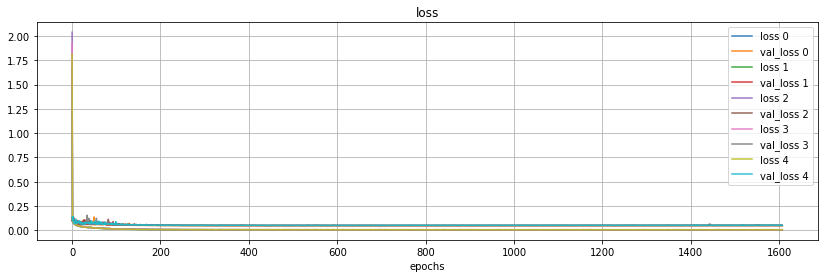

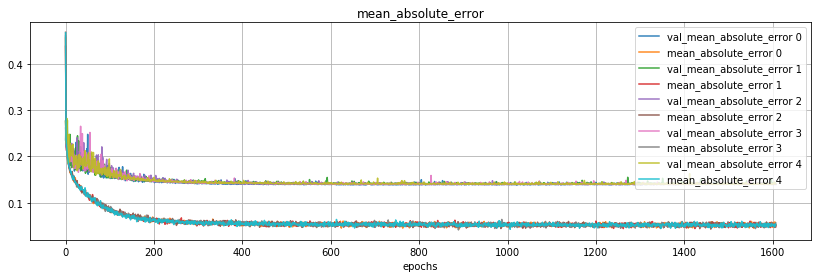

In [37]:
plot_keras_hist(hists)

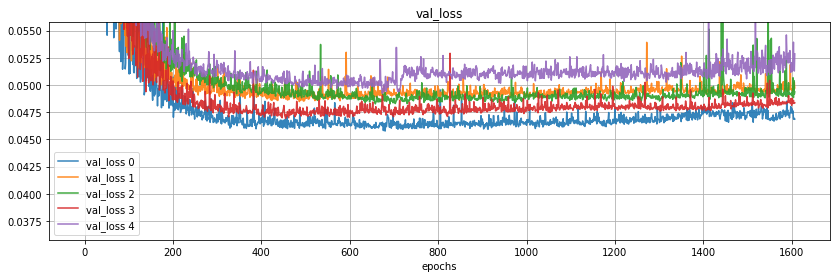

In [38]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss'])-0.01, 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

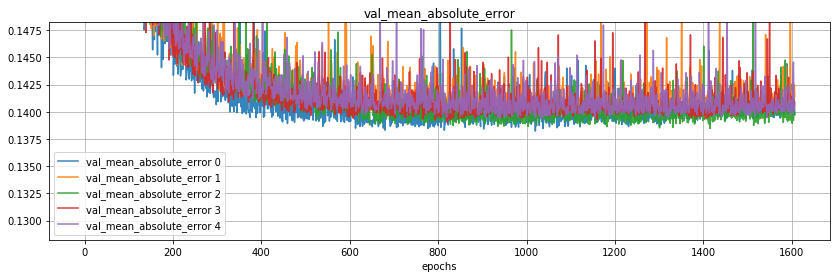

In [39]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_mean_absolute_error'])-0.01, 
                             min(hists[0].history['val_mean_absolute_error'])+0.01), metrics_plot=['val_mean_absolute_error'])

In [40]:
hist.params

{'batch_size': 256,
 'do_validation': True,
 'epochs': 1608,
 'metrics': ['loss',
  'mean_absolute_error',
  'val_loss',
  'val_mean_absolute_error'],
 'samples': 48000,
 'steps': None,
 'verbose': 2}

### One-fold prediction

In [41]:
sorted(best_iterations), np.mean(best_iterations), np.std(best_iterations)

([456, 487, 675, 681, 692], 598.2, 104.05652310162972)

([456, 487, 675, 681, 692], 598.2, 104.05652310162972)

In [57]:
ensemble_epochs(best_iterations)

array([494, 546, 598, 650, 702])

In [56]:
def ensemble_epochs(best_iterations):
    ep_step = max(int(round(np.std(best_iterations)/2)), 1)
    ep_mean = int(round(np.mean(best_iterations)))
    return np.arange(ep_mean-2*ep_step, ep_mean+2*ep_step+1, ep_step)

In [43]:
def concate_keras_hists(hist1, hist2):
    ''' Concate two keras history objects '''
    if hist1 is not None:
        for m in hist2.history:
            hist2.history[m] = hist1.history[m] + hist2.history[m]
        hist2.epoch = hist1.epoch + hist2.epoch
    return hist2

In [44]:
#params['epochs'] = int(np.mean(best_iterations))

In [58]:
params['ensemble_epochs'] = ensemble_epochs(best_iterations)

In [59]:
params

{'batch_norm': True,
 'batch_size': 256,
 'embedding_ratio': 3,
 'ensemble_epochs': array([494, 546, 598, 650, 702]),
 'epochs': 1608,
 'loss': 'mse',
 'n_neurons': (3440, 6880, 1720, 860)}

In [60]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
else:
    cat_n_classes = {}
cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                          cat_n_classes[c]) for c in cat_n_classes}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

# Train model
initial_epoch = 0
y_scaled_pred_ensemble = []
hist = None
for j, epochs in enumerate(params['ensemble_epochs']):
    hist_j = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=epochs, 
                     verbose=2, initial_epoch=initial_epoch)
    print('[', j+1, '/', len(params['ensemble_epochs']),'] ensemble epochs:', epochs)
    hist = concate_keras_hists(hist, hist_j)
    
    model.save_weights(model_name+'-weights-'+'one-'+str(j)+'.h5')
    initial_epoch = epochs
    
    # Predict on test set    
    y_scaled_pred_ensemble.append(model.predict(X_test, batch_size=1024))

# Ensemble average of prediction
y_scaled_pred_ensemble = np.array(y_scaled_pred_ensemble)
print(y_scaled_pred_ensemble.shape)
df_test[col_target+'_scaled_pred'] = y_scaled_pred_ensemble.mean(axis=0)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

Numerical input dims: 138
Embeding  input dims: {'parking_way': 4, 'city': 12, 'building_use': 11, 'building_type': 6, 'building_material': 10, 'town': 203, 'village': 2537, 'encoded_latlon': 7}
Embeding output dims: {'parking_way': 4, 'city': 8, 'building_use': 8, 'building_type': 6, 'building_material': 8, 'town': 16, 'village': 24, 'encoded_latlon': 7}
Total embedding output dims: 81
Epoch 1/494
 - 26s - loss: 1.4393 - mean_absolute_error: 0.4241
Epoch 2/494
 - 19s - loss: 0.0956 - mean_absolute_error: 0.2334
Epoch 3/494
 - 19s - loss: 0.0853 - mean_absolute_error: 0.2200
Epoch 4/494
 - 19s - loss: 0.0765 - mean_absolute_error: 0.2083
Epoch 5/494
 - 19s - loss: 0.0694 - mean_absolute_error: 0.1985
Epoch 6/494
 - 19s - loss: 0.0619 - mean_absolute_error: 0.1868
Epoch 7/494
 - 19s - loss: 0.0581 - mean_absolute_error: 0.1811
Epoch 8/494
 - 19s - loss: 0.0559 - mean_absolute_error: 0.1780
Epoch 9/494
 - 19s - loss: 0.0549 - mean_absolute_error: 0.1770
Epoch 10/494
 - 19s - loss: 0.0525

Epoch 127/494
 - 19s - loss: 0.0093 - mean_absolute_error: 0.0721
Epoch 128/494
 - 19s - loss: 0.0090 - mean_absolute_error: 0.0714
Epoch 129/494
 - 19s - loss: 0.0088 - mean_absolute_error: 0.0723
Epoch 130/494
 - 19s - loss: 0.0094 - mean_absolute_error: 0.0742
Epoch 131/494
 - 19s - loss: 0.0088 - mean_absolute_error: 0.0713
Epoch 132/494
 - 19s - loss: 0.0089 - mean_absolute_error: 0.0726
Epoch 133/494
 - 19s - loss: 0.0082 - mean_absolute_error: 0.0688
Epoch 134/494
 - 19s - loss: 0.0085 - mean_absolute_error: 0.0699
Epoch 135/494
 - 19s - loss: 0.0078 - mean_absolute_error: 0.0672
Epoch 136/494
 - 19s - loss: 0.0081 - mean_absolute_error: 0.0681
Epoch 137/494
 - 19s - loss: 0.0079 - mean_absolute_error: 0.0674
Epoch 138/494
 - 19s - loss: 0.0078 - mean_absolute_error: 0.0677
Epoch 139/494
 - 19s - loss: 0.0081 - mean_absolute_error: 0.0681
Epoch 140/494
 - 19s - loss: 0.0077 - mean_absolute_error: 0.0670
Epoch 141/494
 - 19s - loss: 0.0076 - mean_absolute_error: 0.0665
Epoch 142/

 - 19s - loss: 0.0059 - mean_absolute_error: 0.0600
Epoch 252/494
 - 19s - loss: 0.0058 - mean_absolute_error: 0.0585
Epoch 253/494
 - 19s - loss: 0.0047 - mean_absolute_error: 0.0530
Epoch 254/494
 - 19s - loss: 0.0061 - mean_absolute_error: 0.0605
Epoch 255/494
 - 19s - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 256/494
 - 19s - loss: 0.0050 - mean_absolute_error: 0.0544
Epoch 257/494
 - 19s - loss: 0.0052 - mean_absolute_error: 0.0567
Epoch 258/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0558
Epoch 259/494
 - 19s - loss: 0.0058 - mean_absolute_error: 0.0594
Epoch 260/494
 - 19s - loss: 0.0064 - mean_absolute_error: 0.0623
Epoch 261/494
 - 19s - loss: 0.0055 - mean_absolute_error: 0.0575
Epoch 262/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0536
Epoch 263/494
 - 19s - loss: 0.0053 - mean_absolute_error: 0.0555
Epoch 264/494
 - 19s - loss: 0.0058 - mean_absolute_error: 0.0590
Epoch 265/494
 - 19s - loss: 0.0049 - mean_absolute_error: 0.0535
Epoch 266/494
 - 19s - l

Epoch 376/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0564
Epoch 377/494
 - 19s - loss: 0.0049 - mean_absolute_error: 0.0538
Epoch 378/494
 - 19s - loss: 0.0048 - mean_absolute_error: 0.0526
Epoch 379/494
 - 19s - loss: 0.0045 - mean_absolute_error: 0.0516
Epoch 380/494
 - 19s - loss: 0.0048 - mean_absolute_error: 0.0542
Epoch 381/494
 - 19s - loss: 0.0052 - mean_absolute_error: 0.0561
Epoch 382/494
 - 19s - loss: 0.0043 - mean_absolute_error: 0.0505
Epoch 383/494
 - 19s - loss: 0.0055 - mean_absolute_error: 0.0576
Epoch 384/494
 - 19s - loss: 0.0041 - mean_absolute_error: 0.0502
Epoch 385/494
 - 19s - loss: 0.0048 - mean_absolute_error: 0.0519
Epoch 386/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0558
Epoch 387/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0549
Epoch 388/494
 - 19s - loss: 0.0053 - mean_absolute_error: 0.0569
Epoch 389/494
 - 19s - loss: 0.0044 - mean_absolute_error: 0.0502
Epoch 390/494
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0565
Epoch 391/

Epoch 500/546
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0553
Epoch 501/546
 - 19s - loss: 0.0052 - mean_absolute_error: 0.0563
Epoch 502/546
 - 19s - loss: 0.0052 - mean_absolute_error: 0.0551
Epoch 503/546
 - 19s - loss: 0.0053 - mean_absolute_error: 0.0565
Epoch 504/546
 - 19s - loss: 0.0050 - mean_absolute_error: 0.0547
Epoch 505/546
 - 19s - loss: 0.0045 - mean_absolute_error: 0.0515
Epoch 506/546
 - 19s - loss: 0.0055 - mean_absolute_error: 0.0586
Epoch 507/546
 - 19s - loss: 0.0049 - mean_absolute_error: 0.0556
Epoch 508/546
 - 19s - loss: 0.0047 - mean_absolute_error: 0.0530
Epoch 509/546
 - 19s - loss: 0.0046 - mean_absolute_error: 0.0537
Epoch 510/546
 - 19s - loss: 0.0051 - mean_absolute_error: 0.0549
Epoch 511/546
 - 19s - loss: 0.0048 - mean_absolute_error: 0.0537
Epoch 512/546
 - 19s - loss: 0.0049 - mean_absolute_error: 0.0539
Epoch 513/546
 - 19s - loss: 0.0048 - mean_absolute_error: 0.0537
Epoch 514/546
 - 19s - loss: 0.0046 - mean_absolute_error: 0.0533
Epoch 515/

 - 19s - loss: 0.0040 - mean_absolute_error: 0.0500
Epoch 624/650
 - 19s - loss: 0.0045 - mean_absolute_error: 0.0520
Epoch 625/650
 - 19s - loss: 0.0044 - mean_absolute_error: 0.0518
Epoch 626/650
 - 19s - loss: 0.0053 - mean_absolute_error: 0.0586
Epoch 627/650
 - 19s - loss: 0.0042 - mean_absolute_error: 0.0507
Epoch 628/650
 - 19s - loss: 0.0041 - mean_absolute_error: 0.0511
Epoch 629/650
 - 19s - loss: 0.0044 - mean_absolute_error: 0.0520
Epoch 630/650
 - 19s - loss: 0.0042 - mean_absolute_error: 0.0511
Epoch 631/650
 - 19s - loss: 0.0050 - mean_absolute_error: 0.0551
Epoch 632/650
 - 19s - loss: 0.0038 - mean_absolute_error: 0.0485
Epoch 633/650
 - 19s - loss: 0.0049 - mean_absolute_error: 0.0557
Epoch 634/650
 - 19s - loss: 0.0045 - mean_absolute_error: 0.0523
Epoch 635/650
 - 19s - loss: 0.0041 - mean_absolute_error: 0.0512
Epoch 636/650
 - 19s - loss: 0.0046 - mean_absolute_error: 0.0522
Epoch 637/650
 - 19s - loss: 0.0041 - mean_absolute_error: 0.0499
Epoch 638/650
 - 19s - l

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.359993e+07
1,BTshNOJyKHnT2YIT,4.089902e+06
2,dhdymr0lV8N5kZOT,1.152978e+07
3,VEwyGGMcD56w5BOc,6.070221e+06
4,wmUeMoJZfsqaSX9b,1.109913e+06
5,EtBjGAHmHCe9t7TZ,2.478039e+06
6,hPNH34vmaZtvBtqc,1.246254e+07
7,wXjeI38bYDMJJwZC,6.090898e+06
8,fxZSGX6aPAFKU8W4,1.700906e+06
9,ewr0Fx6ign87OwaV,4.097816e+06


In [61]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

#### Hist

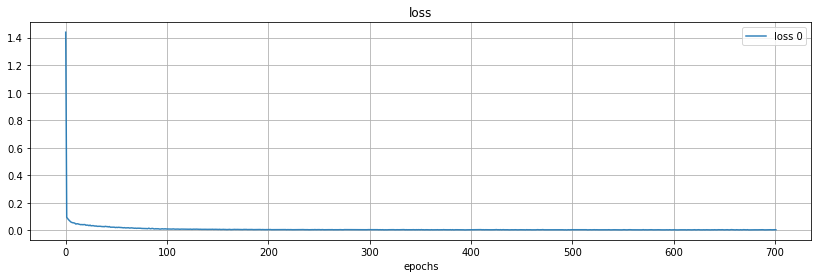

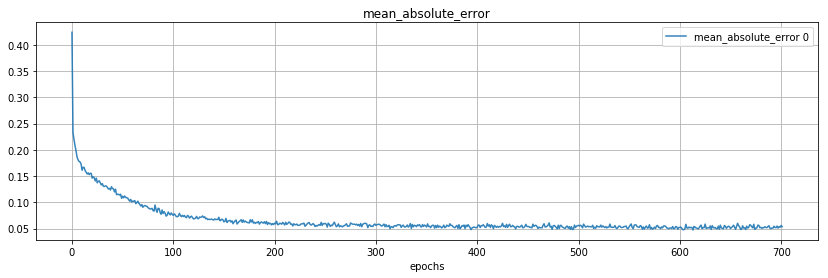

In [62]:
plot_keras_hist(hist)

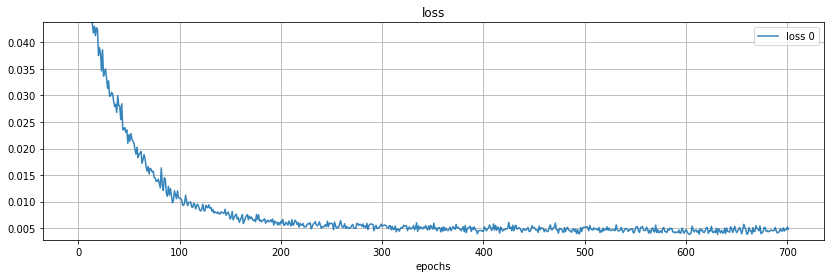

In [63]:
plot_keras_hist(hist, ylim=(min(hist.history['loss'])-0.001, 
                            min(hist.history['loss'])+0.04), metrics_plot=['loss'])

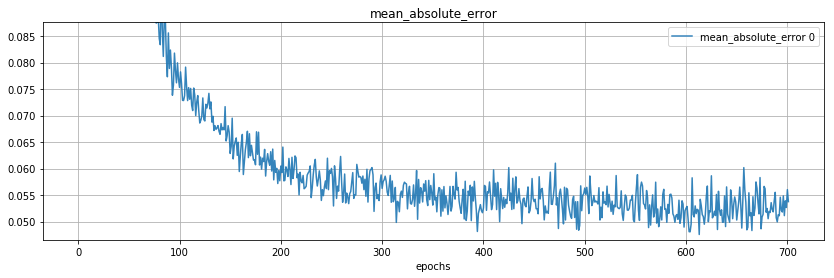

In [64]:
plot_keras_hist(hist, ylim=(min(hist.history['mean_absolute_error'])-0.001, 
                            min(hist.history['mean_absolute_error'])+0.04), metrics_plot=['mean_absolute_error'])

### Result

Leaderboard:
- kfold:
- one ensemble: